# **Для итогового задания по математике решила взять датасет с соревнования (датасет предоставил циан).**

In [3]:
!pip install geopy
!pip install fuzzywuzzy

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from scipy import stats
import seaborn as sns
from fuzzywuzzy import fuzz
import re
import statsmodels.api as sm
import matplotlib as mpl
from utils import *

In [6]:
df = pd.read_csv("main_data.csv")

In [7]:
df.head()

region                                address       price  total_area  \
0    msk  Москва, Большой Толмачёвский переулок  1996610000       459.4   
1    msk              Москва, Самотечная ул., 5    66970000       160.0   
2    msk                        Москва, Ильинка   378820000       157.4   
3    msk             Москва, М. Бронная ул., 32   110500000       110.5   
4    msk                        Москва, Ильинка  1031300000       271.8   

   kitchen_area  living_area  rooms_count  floor  floors_number  build_date  \
0          81.4        173.3          5.0      7              8         NaN   
1          25.0        119.0          3.0      3              9      1892.0   
2          41.1         50.7          3.0      3              5         NaN   
3          15.0         61.0          3.0      2              6      1912.0   
4          57.1        123.8          5.0      5              5         NaN   

   ...  longitude   latitude passenger_elevator cargo_elevator  \
0  ...  37.620949  55.739757                1.0            1.0   
1  ...  37.618318  55.775165                1.0            1.0   
2  ...  37.623649  55.755140                NaN            NaN   
3  ...  37.593524  55.764197                1.0            0.0   
4  ...  37.623509  55.755201                NaN            NaN   

                                     metro  metro_distance  \
0      Полянка,Новокузнецкая,Третьяковская          6,10,4   
1  Цветной бульвар,Достоевская,Сухаревская          6,9,13   
2            Площадь Революции,Театральная             3,6   
3           Маяковская,Пушкинская,Тверская        10,10,10   
4            Площадь Революции,Театральная             3,6   

       metro_transport         district  is_apartments  is_auction  
0  walk,walk,transport     Якиманка,ЦАО            0.0           0  
1       walk,walk,walk     Тверской,ЦАО            NaN           1  
2            walk,walk     Тверской,ЦАО            0.0           0  
3       walk,walk,walk  Пресненский,ЦАО            NaN           1  
4            walk,walk     Тверской,ЦАО            0.0           0  

[5 rows x 26 columns]

In [8]:
df.shape

(5978, 26)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5978 entries, 0 to 5977
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   region              5978 non-null   object 
 1   address             5978 non-null   object 
 2   price               5978 non-null   int64  
 3   total_area          5978 non-null   float64
 4   kitchen_area        3702 non-null   float64
 5   living_area         3834 non-null   float64
 6   rooms_count         5248 non-null   float64
 7   floor               5978 non-null   int64  
 8   floors_number       5978 non-null   int64  
 9   build_date          1497 non-null   float64
 10  isСomplete          3797 non-null   float64
 11  complitation_year   3869 non-null   float64
 12  house_material      5371 non-null   object 
 13  parking             1432 non-null   object 
 14  decoration          1222 non-null   object 
 15  balcony             1405 non-null   float64
 16  longit

# **Пропуски, перекодирование признаков, создание новых**

In [10]:
for col in df.columns:
  print(f'{col}: {df[col].isna().sum() / df.shape[0] * 100:.2f}%')

region: 0.00%
address: 0.00%
price: 0.00%
total_area: 0.00%
kitchen_area: 38.07%
living_area: 35.86%
rooms_count: 12.21%
floor: 0.00%
floors_number: 0.00%
build_date: 74.96%
isСomplete: 36.48%
complitation_year: 35.28%
house_material: 10.15%
parking: 76.05%
decoration: 79.56%
balcony: 76.50%
longitude: 0.00%
latitude: 0.00%
passenger_elevator: 45.57%
cargo_elevator: 54.95%
metro: 14.62%
metro_distance: 14.62%
metro_transport: 14.62%
district: 0.28%
is_apartments: 15.69%
is_auction: 0.00%


## для наглядности построим heatmap с пропусками

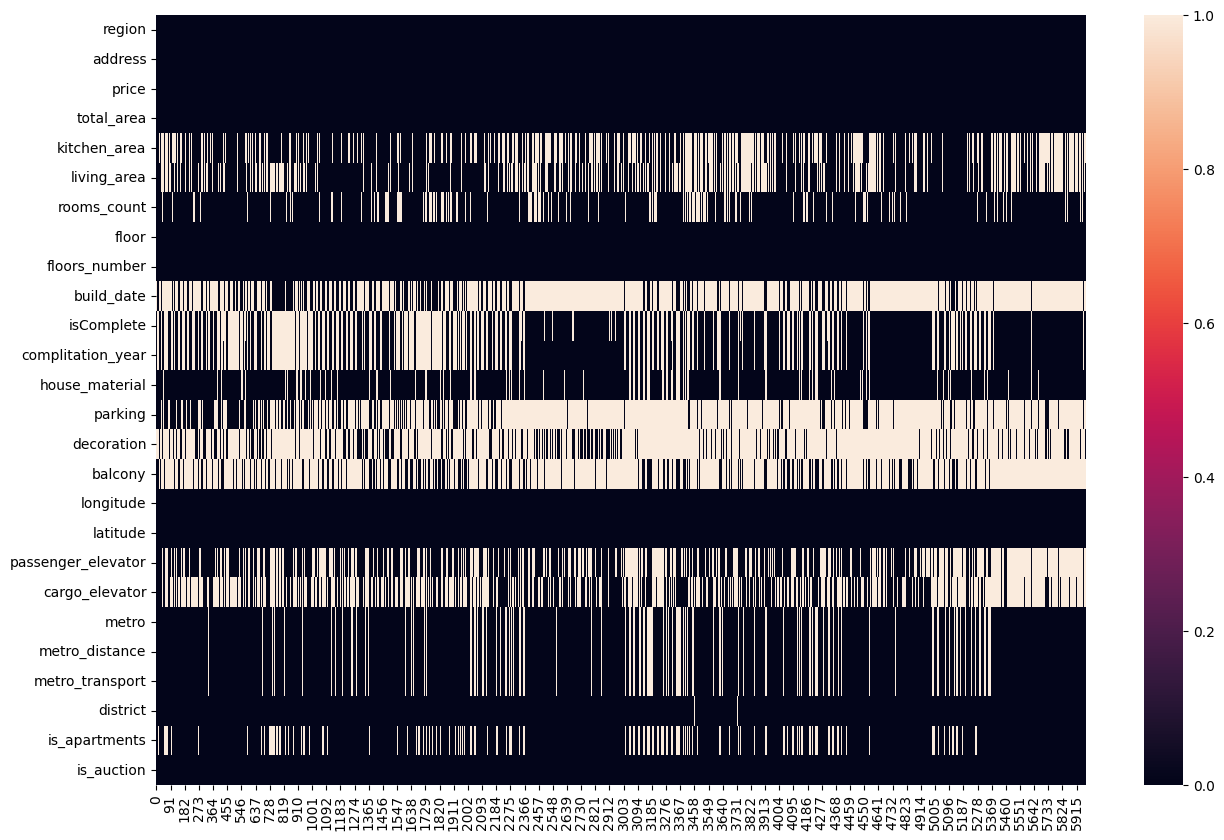

In [11]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.isna().transpose());

## Проанализируем какие города встречаются в нашем датасете

In [12]:
mpl.rcParams.update({
    "axes.facecolor": "#101010",  # Цвет фона осей
    "figure.facecolor": "#101010",  # Цвет фона всей фигуры
    "axes.grid": True,
    "grid.color": "white",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "text.color": "white",
})

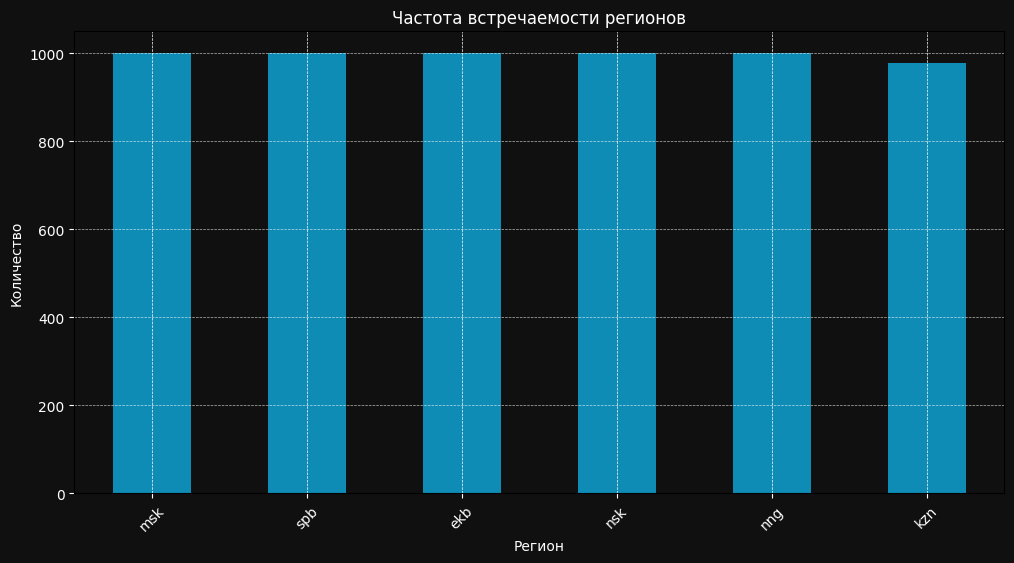

In [13]:
plt.figure(figsize=(12, 6))
df['region'].value_counts().plot(kind='bar', color='#0e8cb5')

plt.xlabel('Регион')
plt.ylabel('Количество')
plt.title('Частота встречаемости регионов')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## *Распределение городов примерно одинаковое(около 1000)*

##Посмотрим в каких домах(количество этажей) нет лифтов в разных городах

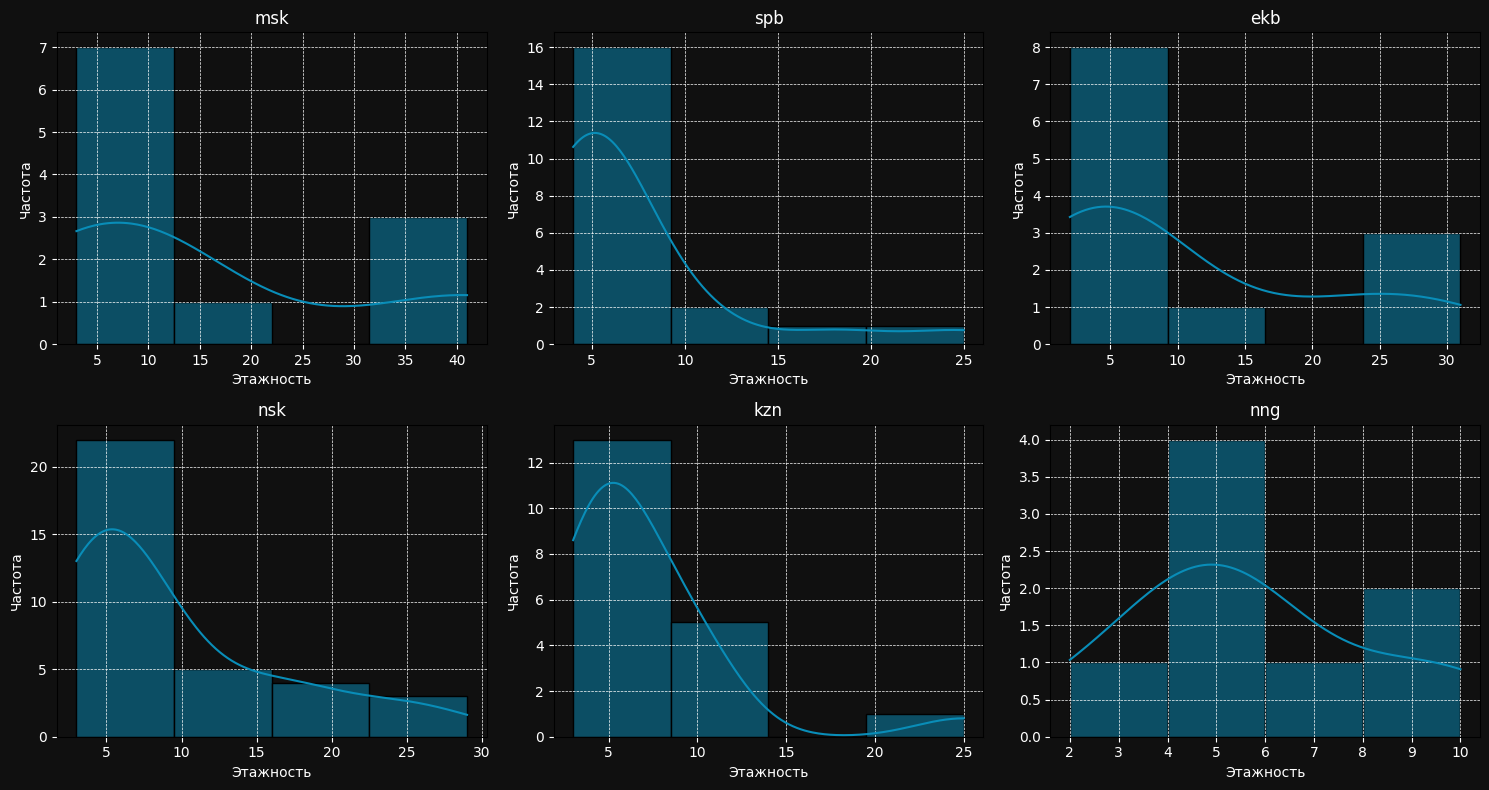

In [14]:
df_no_elevator = df[df['passenger_elevator'] == 0]
cities = df_no_elevator['region'].unique()

cols = 3
rows = -(-len(cities) // cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))

axes = axes.flatten() if rows > 1 else [axes]

for i, city in enumerate(cities):
    city_data = df_no_elevator[df_no_elevator['region'] == city]

    sns.histplot(city_data['floors_number'], kde=True, bins=4, ax=axes[i], color='#098db8')
    axes[i].set_title(f'{city}')
    axes[i].set_xlabel('Этажность')
    axes[i].set_ylabel('Частота')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## В среднем лифта нет ниже 5-6 этажей, что логично
## Очень интересные данные, например в казани, новосибирске, нижнем новгороде и моске есть дома без лифтов от 25 до 40 этажей. Я посчитала, что все же этo ошибка и лифт там должен быть, поэтому заменила на 1(если дом выше 7 этаже => есть лифт).

In [15]:
df.loc[(df['passenger_elevator'].isna()) & (df['floors_number'] <= 6), 'passenger_elevator'] = 0
df.loc[(df['floors_number'] >= 7) & (df['passenger_elevator'].isna()), 'passenger_elevator'] = 1
df.loc[(df['floors_number'] >=7 ) & (df['passenger_elevator'] == 0), 'passenger_elevator'] = 1
df['cargo_elevator'].isna().sum()

np.int64(3285)

## Так же в датасете есть признак - грузовой лифт
## Посмотрим на распределение


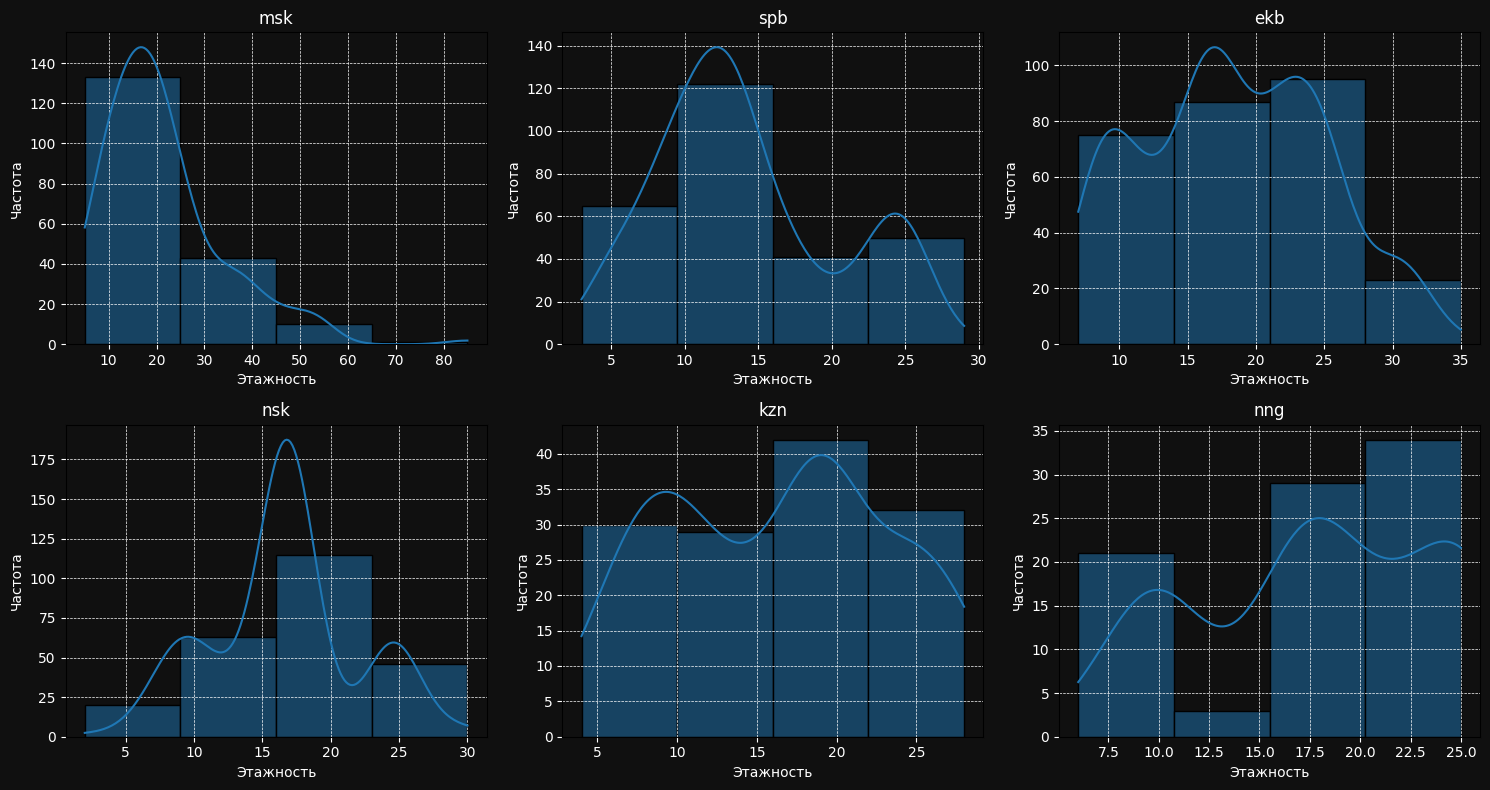

In [16]:
df_no_elevator = df[df['cargo_elevator'] == 1 ]

cols = 3
rows = -(-len(cities) // cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))

axes = axes.flatten() if rows > 1 else [axes]

for i, city in enumerate(cities):
    city_data = df_no_elevator[df_no_elevator['region'] == city]

    sns.histplot(city_data['floors_number'], kde=True, bins=4, ax=axes[i])
    axes[i].set_title(f'{city}')
    axes[i].set_xlabel('Этажность')
    axes[i].set_ylabel('Частота')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## В среднем выше в зданиях выше 10 этажей есть грузовой лифт, если этажность меньше 10 => грузового лифта нет

In [17]:
df.loc[(df['cargo_elevator'].isna()) & (df['floors_number'] <= 10), 'cargo_elevator'] = 0
df.loc[(df['cargo_elevator'].isna()) & (df['floors_number'] > 10), 'cargo_elevator'] = 1
df['cargo_elevator'].isna().sum()

np.int64(0)

## Посмотрим на среднюю общую площадь и количество комнат в целом по датасету.

<ipython-input-18-2251464c798f>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rooms_count', y='total_area', data=avg_area_by_rooms, palette='Blues_d')


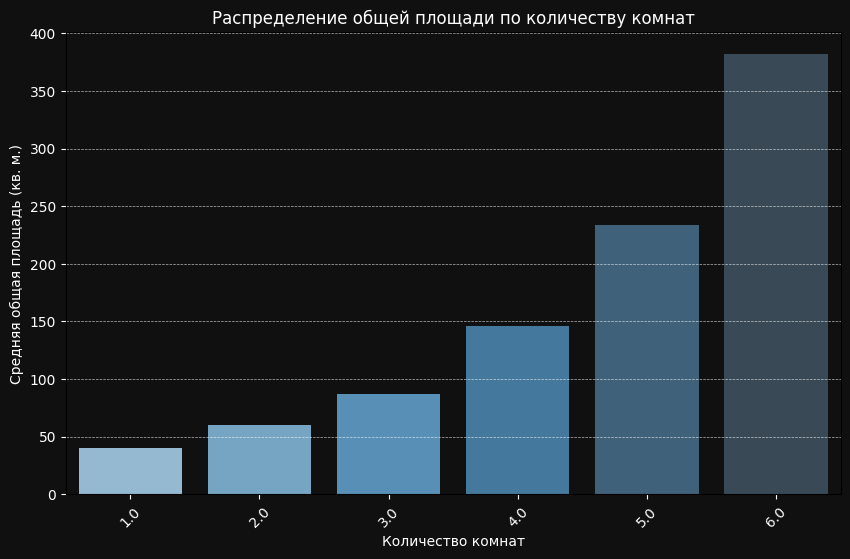

In [18]:
avg_area_by_rooms = df.groupby('rooms_count')['total_area'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='rooms_count', y='total_area', data=avg_area_by_rooms, palette='Blues_d')

plt.xlabel("Количество комнат")
plt.ylabel("Средняя общая площадь (кв. м.)")
plt.title("Распределение общей площади по количеству комнат")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

## Всеже города застраивались в разное время => могут отличаться средние площади для каждого города

<ipython-input-19-4031ff4326ec>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rooms_count', y='total_area', data=avg_area_by_rooms, ax=ax, palette='Blues_d')
<ipython-input-19-4031ff4326ec>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-19-4031ff4326ec>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rooms_count', y='total_area', data=avg_area_by_rooms, ax=ax, palette='Blues_d')
<ipython-input-19-4031ff4326ec>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a 

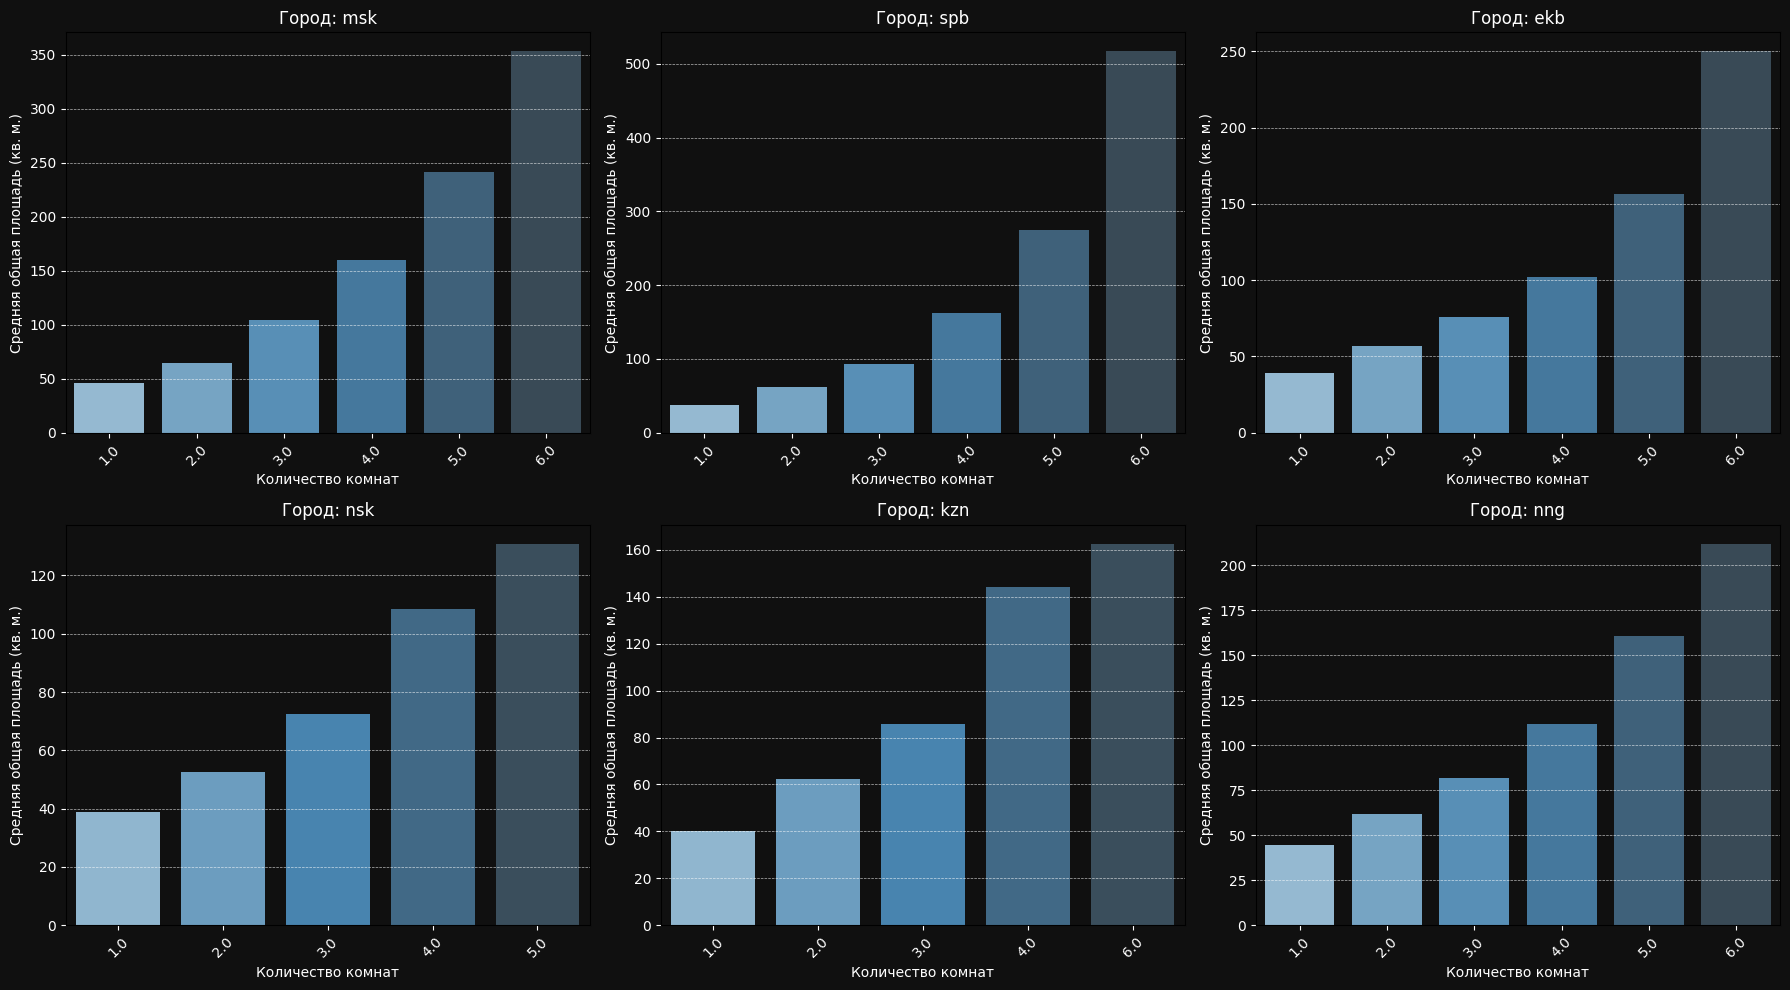

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i, city in enumerate(cities):
    ax = axes[i // 3, i % 3]

    city_data = df[df['region'] == city]
    avg_area_by_rooms = city_data.groupby('rooms_count')['total_area'].mean().reset_index()

    sns.barplot(x='rooms_count', y='total_area', data=avg_area_by_rooms, ax=ax, palette='Blues_d')

    ax.set_xlabel("Количество комнат")
    ax.set_ylabel("Средняя общая площадь (кв. м.)")
    ax.set_title(f"Город: {city}")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()


## *Действительно, средние площади при одинаковом количестве комнат в разных городах отличаются*


##**Попробуем заполнить пропуски в колонке с количеством комнат**

## Количество комнат скорее всего зависит от общей площади квартиры, поэтому для заполнения пропусков я взяла среднюю площадь для разного количества комнат и вычитала из нее известную площадь, смотрела к какому типо она ближе всего.

In [20]:
for city in cities:
    city_data = df[df['region'] == city]
    avg_area_by_rooms = city_data.groupby('rooms_count')['total_area'].mean().reset_index()
    missing_rooms = city_data[city_data['rooms_count'].isna()]

    for index, row in missing_rooms.iterrows():
        closest_room_count = avg_area_by_rooms.iloc[(avg_area_by_rooms['total_area'] - row['total_area']).abs().argmin()]['rooms_count']
        df.loc[index, 'rooms_count'] = closest_room_count

missing_after = df['rooms_count'].isna().sum()
print(f"Осталось пропусков в rooms_count: {missing_after}")

Осталось пропусков в rooms_count: 0


## Заполним пропуски в колонке is_apartments. Я рассуждала так - апартаменты появились относительно недавно, скорее всего позже 2006 года

In [21]:
df[(df['is_apartments'] == 1) & (df['build_date'] < 2006)].head()

region                                       address     price  \
40     msk  Россия, Москва, Комсомольский проспект, 23/7  30047200   
441    msk       Россия, Москва, улица Маросейка, 11/4с1  55000000   
545    msk       Россия, Москва, Профсоюзная улица, 18к1  18900000   
810    msk  Россия, Москва, Комсомольский проспект, 23/7  24391000   
862    msk               Москва, Дмитровское шоссе, 46к1   4550000   

     total_area  kitchen_area  living_area  rooms_count  floor  floors_number  \
40         58.8          29.0          NaN          1.0      2              9   
441        46.3          17.0         25.0          1.0      2              3   
545        63.2           NaN          NaN          2.0      1              9   
810        41.4          18.5          NaN          1.0      2              9   
862        13.1           NaN          NaN          1.0      2              8   

     build_date  ...  longitude   latitude passenger_elevator cargo_elevator  \
40       1961.0  ...  37.583598  55.727212                1.0            0.0   
441      1917.0  ...  37.636096  55.758103                1.0            0.0   
545      1954.0  ...  37.567258  55.683077                1.0            0.0   
810      1961.0  ...  37.583598  55.727212                1.0            0.0   
862      1961.0  ...  37.569962  55.843919                1.0            0.0   

                                         metro  metro_distance  \
40        Фрунзенская,Парк Культуры,Спортивная         4,16,20   
441         Китай-город,Лубянка,Кузнецкий мост          3,7,12   
545  Академическая,Профсоюзная,Новые Черёмушки          7,7,20   
810       Фрунзенская,Парк Культуры,Спортивная         4,16,20   
862             Петровско-Разумовская,Окружная             8,8   

     metro_transport            district  is_apartments  is_auction  
40    walk,walk,walk       Хамовники,ЦАО            1.0           1  
441   walk,walk,walk       Басманный,ЦАО            1.0           1  
545   walk,walk,walk  Академический,ЮЗАО            1.0           1  
810   walk,walk,walk       Хамовники,ЦАО            1.0           1  
862        walk,walk   Тимирязевский,САО            1.0           1  

[5 rows x 26 columns]

## *Действительно - мало апартаментов, построенных до 2006 года, так же гугл утверждает что квартиры минимум 28 квадратным метров => все что меньше - явно апартаменты*

In [22]:
df.loc[(df['is_apartments'].isna()) & (df['total_area'] < 28), 'is_apartments'] = 1
df.loc[(df['is_apartments'].isna()) & (df['build_date'] < 2006), 'is_apartments'] = 0
df['is_apartments'].isna().sum()

np.int64(600)

## Предположу, что квартиры, площадь которых больше 350 - апартаменты
## Так же жилая площадь не может быть меньше 28, кухня не может быть меньше 8 => апартаменты (это мое предположение, не претендую на правду)

In [23]:
df.loc[(df['is_apartments'].isna()) & (df['total_area'] > 350), 'is_apartments'] = 1
df.loc[(df['is_apartments'].isna()) & (df['living_area'] < 28), 'is_apartments'] = 1
df.loc[(df['is_apartments'].isna()) & (df['kitchen_area'] < 8), 'is_apartments'] = 1
df.loc[(df['is_apartments'].isna()), 'is_apartments'] = 0
df['is_apartments'].isna().sum()

np.int64(0)

## Попробуем заполнить пропуски в колонке balcony, посмотрим на общее распределение

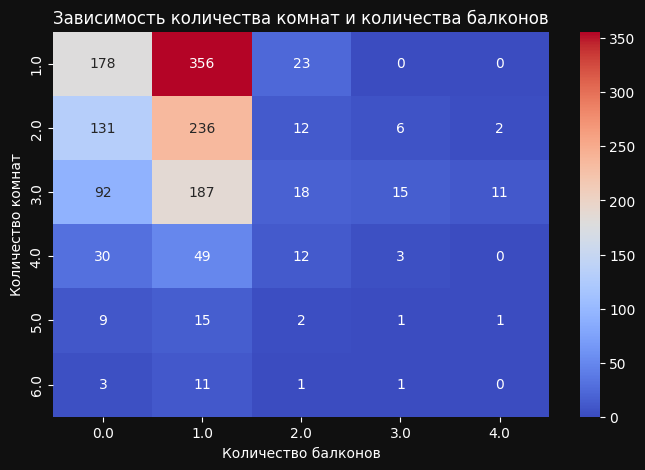

In [24]:
room_balcony_counts = df.groupby(['rooms_count', 'balcony']).size().unstack(fill_value=0)

plt.figure(figsize=(8, 5))
sns.heatmap(room_balcony_counts, annot=True, cmap='coolwarm', fmt='d')

plt.xlabel('Количество балконов')
plt.ylabel('Количество комнат')
plt.title('Зависимость количества комнат и количества балконов')
plt.grid(axis='y', linestyle='', alpha=0.7)
plt.grid(axis='x', linestyle='', alpha=0.7)
plt.show()


## Скорее всего на первом этаже явно не будет балконов, так же нет балконов в зданиях с этажностью выше 40

In [25]:
df.loc[(df['balcony'].isna().sum()) & (df['floor'] == 1), 'balcony'] = 0
df.loc[(df['balcony'].isna().sum()) & (df['floors_number'] > 35), 'balcony'] = 0

## считаем, что количество балконов не может превышать количества комнат + 1 (условно в каждой комнате по балкону + на кухне балкон)

In [26]:
df_with_balconies = df[df['balcony'] > 0].copy()
df_with_balconies.loc[df_with_balconies['balcony'] > df_with_balconies['rooms_count'] + 1, 'balcony'] = df_with_balconies['rooms_count']
df.update(df_with_balconies)


### Посмотрим на среднюю площадь, среднюю этажность здания и количество балконов

<ipython-input-27-7a5fdbd9486c>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_area_by_balcony['balcony'],
<ipython-input-27-7a5fdbd9486c>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_floors_by_balcony['balcony'],


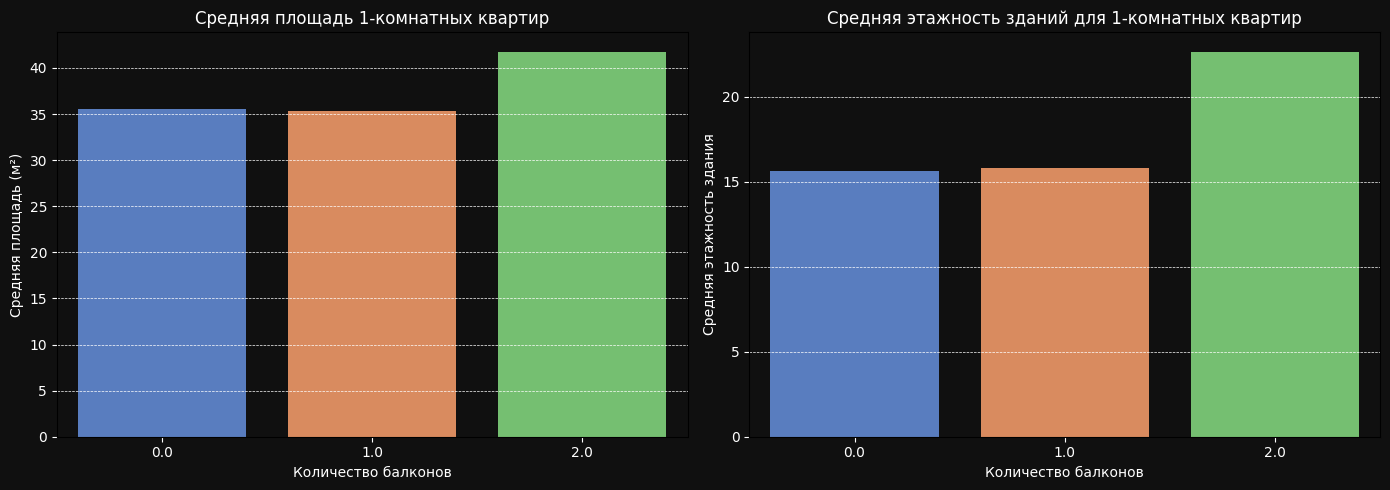

In [27]:
def plot_balcony_stats(df, rooms_count):
    df_filtered = df[df['rooms_count'] == rooms_count]
    avg_area_by_balcony = df_filtered.groupby('balcony')['total_area'].mean().reset_index()
    avg_floors_by_balcony = df_filtered.groupby('balcony')['floors_number'].mean().reset_index()

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    sns.barplot(x=avg_area_by_balcony['balcony'],
                y=avg_area_by_balcony['total_area'],
                palette='muted',
                ax=axes[0])
    axes[0].set_xlabel('Количество балконов')
    axes[0].set_ylabel('Средняя площадь (м²)')
    axes[0].set_title(f'Средняя площадь {rooms_count}-комнатных квартир')


    sns.barplot(x=avg_floors_by_balcony['balcony'],
                y=avg_floors_by_balcony['floors_number'],
                palette='muted',
                ax=axes[1])
    axes[1].set_xlabel('Количество балконов')
    axes[1].set_ylabel('Средняя этажность здания')
    axes[1].set_title(f'Средняя этажность зданий для {rooms_count}-комнатных квартир')

    plt.tight_layout()
    plt.show()

plot_balcony_stats(df, 1)

### если квартира более 35 метров и этажность более 16 => два балкона
### в противном случае из графика зависимости возьмем примерные вероятности распределения - либо 0 балконов, либо 1

In [28]:
df.loc[(df['total_area'] > 35) & (df['floors_number'] > 17) & (df['rooms_count'] == 1) & (df['balcony'].isna().sum()), 'balcony'] = 2

In [29]:
mask = (df['rooms_count'] == 1) & (df['balcony'].isna())
df.loc[mask, 'balcony'] = np.random.choice([0, 1], size=mask.sum(), p=[1/3, 2/3])
df['balcony'].isna().sum()

np.int64(2394)

<ipython-input-27-7a5fdbd9486c>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_area_by_balcony['balcony'],
<ipython-input-27-7a5fdbd9486c>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_floors_by_balcony['balcony'],


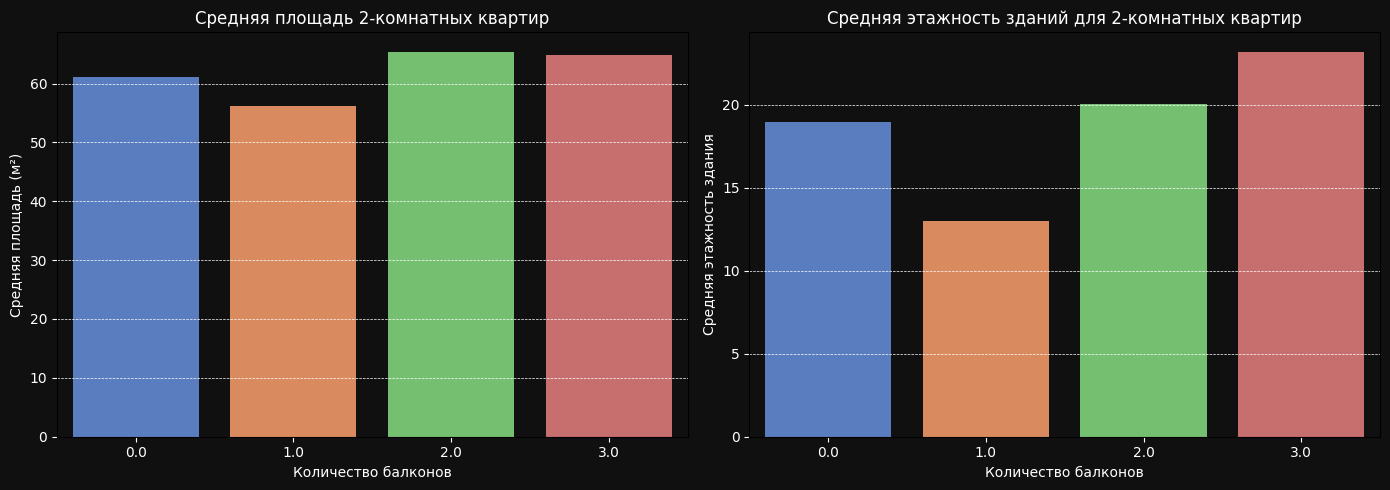

In [30]:
plot_balcony_stats(df, 2)

### Тут как будто бы неправильно все что ниже 15 заполнять 1. Поэтому просто смотрим на распределения.

In [31]:
mask = (df['rooms_count'] == 2) & (df['balcony'].isna())
df.loc[mask, 'balcony'] = np.random.choice([0, 1, 2], size=mask.sum(), p=[0.34, 0.62, 0.04])
df['balcony'].isna().sum()

np.int64(1038)

<ipython-input-27-7a5fdbd9486c>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_area_by_balcony['balcony'],
<ipython-input-27-7a5fdbd9486c>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_floors_by_balcony['balcony'],


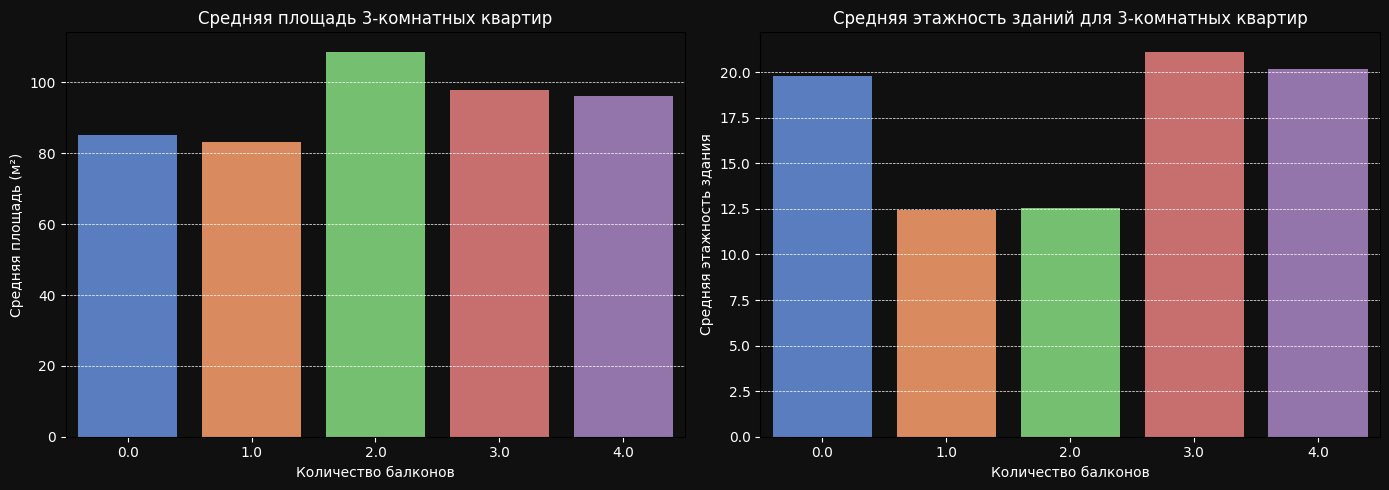

In [32]:
plot_balcony_stats(df, 3)

### Если этажность меньше 13, то надо случайным образом задать в соответствие с распределением количества балконов.

In [33]:
mask = (df['rooms_count'] == 3) & (df['balcony'].isna()) & (df['floors_number'] < 13)
df.loc[mask, 'balcony'] = np.random.choice([1, 2], size=mask.sum(), p=[0.9, 0.1])
mask = (df['rooms_count'] == 3) & (df['balcony'].isna()) & (df['floors_number'] >= 13)
df.loc[mask, 'balcony'] = np.random.choice([0, 3, 4], size=mask.sum(), p=[0.78, 0.11, 0.11])
df['balcony'].isna().sum()

np.int64(255)

<ipython-input-27-7a5fdbd9486c>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_area_by_balcony['balcony'],
<ipython-input-27-7a5fdbd9486c>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_floors_by_balcony['balcony'],


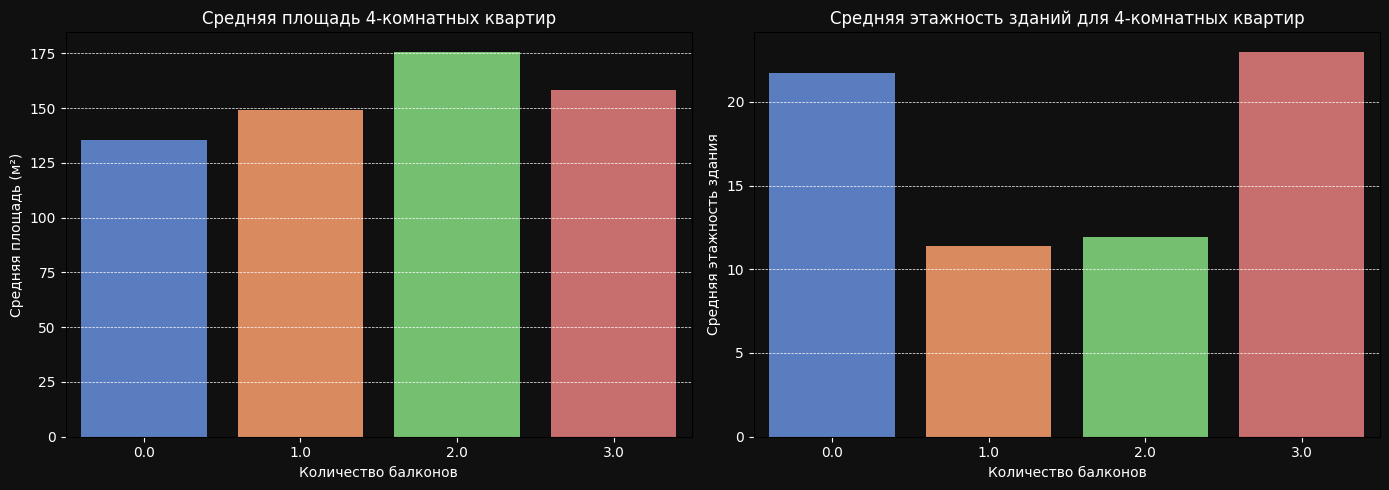

In [34]:
plot_balcony_stats(df, 4)

### Если этажность здания меньше 12, то мы должны заполнить либо 1, либо 2. В противном случае берем 0 и 3.

In [35]:
mask = (df['rooms_count'] == 4) & (df['balcony'].isna()) & (df['floors_number'] < 12)
df.loc[mask, 'balcony'] = np.random.choice([1, 2], size=mask.sum(), p=[0.8, 0.2])
mask = (df['rooms_count'] == 4) & (df['balcony'].isna()) & (df['floors_number'] >= 12)
df.loc[mask, 'balcony'] = np.random.choice([0, 3], size=mask.sum(), p=[0.9, 0.1])
df['balcony'].isna().sum()

np.int64(96)

### В остальных случаях мы говорим, что в квартирах по два балкона

In [36]:
mask = (df['balcony'].isna())
df.loc[mask, 'balcony'] = 2

## Долее я попробовала проанализировать из чего были построены здания в каждом городе и заполнить пропуски

In [37]:
df_nsk = df[df['region'] == 'nsk']
material_counts = df_nsk['house_material'].value_counts()
material_counts

house_material
monolithBrick    436
monolith         153
brick            138
panel             93
Name: count, dtype: int64

## Видим, что в Новосибирске в основном использовался монолитный кирпич, заполнять все пропуски одной модой не целесообразно, так как разные районы застраивались в разные годы. Решила проанализировать конктретные районы и заполнить пропуски модой по району, оставшие пропуски - модой по городу

In [38]:
cities = df['region'].unique()

for city in cities:
    df_city = df[df['region'] == city]
    districts_with_missing = df_city[df_city['house_material'].isna()]['district'].unique()

    for district in districts_with_missing:
        mode_value = df_city.loc[df_city['district'] == district, 'house_material'].mode()
        if not mode_value.empty:
            df.loc[(df['region'] == city) & (df['district'] == district) & (df['house_material'].isna()), 'house_material'] = mode_value[0]

    for city in cities:
        city_mode = df.loc[df['region'] == city, 'house_material'].mode()
        if not city_mode.empty:
            df.loc[(df['region'] == city) & (df['house_material'].isna()), 'house_material'] = city_mode[0]

missing_after = df['house_material'].isna().sum()
print(f"Осталось пропусков в house_material: {missing_after}")


Осталось пропусков в house_material: 0


### Аналогично я сделала со всеми городами

### Заполним пропуски признака metro_transport. В зависимости от города и района смотрим моду по району как можно добраться до метро и заполняем пропуски.

In [39]:
for city in df['region'].unique():
    city_data = df[df['region'] == city]

    districts_with_missing = city_data[city_data['metro_transport'].isna()]['district'].unique()

    city_mode = city_data['metro_transport'].dropna().mode()
    city_mode_value = city_mode[0] if not city_mode.empty else None

    for district in districts_with_missing:
        district_mode = city_data[city_data['district'] == district]['metro_transport'].dropna().mode()

        if not district_mode.empty:
            mode_value = district_mode[0]
        else:
            mode_value = city_mode_value

        df.loc[(df['region'] == city) & (df['district'] == district) & (df['metro_transport'].isna()), 'metro_transport'] = mode_value

df['metro_transport'].isna().sum()

np.int64(0)

###Для удобства перекодируем walk - 1, transport - 0

In [40]:
df['metro_transport'] = df['metro_transport'].apply(
    lambda x: 1 if pd.notna(x) and 'walk' in x.split(',') else 0 if pd.notna(x) else x
)

## Взяла min расстояний, дальше в зависимости от района и города брала среднее по району для пропусков.

In [41]:
def get_min_distance(value):
    if pd.isna(value):
        return value
    try:
        return min(map(float, str(value).split(',')))
    except ValueError:
        return np.nan

df['metro_distance'] = df['metro_distance'].apply(get_min_distance)

In [42]:
for city in df['region'].unique():
    city_data = df[df['region'] == city]

    city_mean = city_data['metro_distance'].mean(skipna=True)

    for district in city_data['district'].unique():
        district_data = city_data[city_data['district'] == district]
        district_mean = district_data['metro_distance'].mean(skipna=True)

        mean_value = district_mean if not pd.isna(district_mean) else city_mean
        df.loc[(df['region'] == city) & (df['district'] == district) & (df['metro_distance'].isna()), 'metro_distance'] = mean_value

print(df['metro_distance'].isna().sum())

0


## **Использование геоданных для заполнения пропусков**

### Попробуем теперь восстановить район

In [43]:
df_missed_district = df[df['district'].isna()]
df_missed_district.head()

region                                            address    price  \
3459    nsk  Новосибирск, Кировский район, Затулинский жилм...  3450000   
3479    nsk  Новосибирск, Кировский район, Затулинский жилм...  3700000   
3483    nsk  Новосибирск, Кировский район, Затулинский жилм...  3750000   
3493    nsk  Новосибирск, Затулинский жилмассив, улица Зорг...  3900000   
3525    nsk                  Новосибирск, Кедровая улица, 80/2  4150000   

      total_area  kitchen_area  living_area  rooms_count  floor  \
3459       32.71           NaN          NaN          1.0      4   
3479       34.16           NaN          NaN          1.0     23   
3483       35.48           NaN          NaN          1.0     17   
3493       36.43           NaN          NaN          1.0     23   
3525       39.80           NaN          NaN          1.0      1   

      floors_number  build_date  ...  longitude   latitude passenger_elevator  \
3459             27         NaN  ...  82.924535  54.927501                3.0   
3479             27         NaN  ...  82.923430  54.927134                3.0   
3483             27         NaN  ...  82.924535  54.927501                3.0   
3493             27         NaN  ...  82.922460  54.926963                3.0   
3525             17         NaN  ...  82.923259  55.123801                1.0   

     cargo_elevator                                        metro  \
3459            1.0    Площадь Маркса,Студенческая,Речной вокзал   
3479            1.0    Площадь Маркса,Студенческая,Речной вокзал   
3483            1.0    Площадь Маркса,Студенческая,Речной вокзал   
3493            1.0    Площадь Маркса,Студенческая,Речной вокзал   
3525            1.0  Заельцовская,Гагаринская,Маршала Покрышкина   

      metro_distance  metro_transport  district  is_apartments  is_auction  
3459            10.0                0       NaN            0.0           0  
3479            10.0                0       NaN            0.0           0  
3483            10.0                0       NaN            0.0           0  
3493            10.0                0       NaN            0.0           0  
3525            11.0                0       NaN            0.0           0  

[5 rows x 26 columns]

In [44]:
df_known_district = df.dropna(subset=['district'])

df_missed_district = df_missed_district[df_missed_district['region'] =='nsk']
df_known_district = df_known_district[df_known_district['region'] =='nsk']

In [45]:
df_nsk = df[df['region'] == 'nsk']

nsk_districts = {}

for district in df_nsk['district'].dropna().unique():
    district_data = df_nsk[df_nsk['district'] == district]
    avg_lat = district_data['latitude'].mean()
    avg_lon = district_data['longitude'].mean()
    nsk_districts[district] = (avg_lat, avg_lon)

In [46]:
def find_closest_district(missed_lat, missed_lon, district_coords):
    closest_district = None
    min_distance = float('inf')
    for district, (lat, lon) in district_coords.items():
        distance = geodesic((missed_lat, missed_lon), (lat, lon)).meters
        if distance < min_distance:
            min_distance = distance
            closest_district = district

    return closest_district

df_missed_district = df[df['district'].isna()]
df_missed_district_original = df_missed_district.copy()


for idx, row in df[df['district'].isna()].iterrows():
    missed_lat = row['latitude']
    missed_lon = row['longitude']
    closest_district = find_closest_district(missed_lat, missed_lon, nsk_districts)
    if closest_district:
        df.at[idx, 'district'] = closest_district

for idx, row in df_missed_district_original.iterrows():
    if row['district'] != df.at[idx, 'district']:
        print(f"Адрес: {df.at[idx, 'district']}")
        print(f"Широта: {row['latitude']}, Долгота: {row['longitude']}")

Адрес: Затулинский,Кировский
Широта: 54.927501, Долгота: 82.924535
Адрес: Затулинский,Кировский
Широта: 54.927134, Долгота: 82.92343
Адрес: Затулинский,Кировский
Широта: 54.927501, Долгота: 82.924535
Адрес: Затулинский,Кировский
Широта: 54.926963, Долгота: 82.92246
Адрес: Стрижи,Заельцовский
Широта: 55.123801, Долгота: 82.923259
Адрес: Затулинский,Кировский
Широта: 54.927501, Долгота: 82.924535
Адрес: Родники,Калининский
Широта: 55.123399, Долгота: 82.924104
Адрес: Затулинский,Кировский
Широта: 54.926963, Долгота: 82.92246
Адрес: Затулинский,Кировский
Широта: 54.927501, Долгота: 82.924535
Адрес: Затулинский,Кировский
Широта: 54.927134, Долгота: 82.92343
Адрес: Стрижи,Заельцовский
Широта: 55.123801, Долгота: 82.923259
Адрес: Затулинский,Кировский
Широта: 54.926963, Долгота: 82.92246
Адрес: Затулинский,Кировский
Широта: 54.927501, Долгота: 82.924535
Адрес: Затулинский,Кировский
Широта: 54.927501, Долгота: 82.924535
Адрес: Родники,Калининский
Широта: 55.123399, Долгота: 82.924104
Адрес: С

In [47]:
df['district'].isna().sum()

np.int64(0)

### Создам признак расстояния до центра города, так как мы знаем долготу и широту и город

In [48]:
city_center_coords = {
    'msk': (55.7558, 37.6173),
    'spb': (59.9343, 30.3351),
    'ekb': (56.8389, 60.6057),
    'nsk': (55.0084, 82.9357),
    'kzn': (55.8304, 49.0661),
    'nng': (56.2965, 43.9361)
}

In [49]:
def calculate_center_distance(lat, lon, city):
    if city in city_center_coords:
        city_lat, city_lon = city_center_coords[city]
        return geodesic((lat, lon), (city_lat, city_lon)).meters
    else:
        return None

df['center_distance'] = df.apply(lambda row: calculate_center_distance(row['latitude'], row['longitude'], row['region']), axis=1).round(3)

### Для удобства перекодируем районы

In [50]:
df_copy = df.copy()

In [51]:
 msk_dict = {
    'ЦАО': 10,
    'ЗАО': 9,
    'САО': 8,
    'ЮЗАО': 7,
    'ЮАО': 6,
    'СЗАО': 5,
    'ВАО': 4,
    'ЮВАО': 3,
    'СВАО': 2,
    'ТиНАО': 1
 }

df['ao'] = df['district'].str.split(',').str[-1]
df['ao'] = df['district'].str.split(',').str[-1]

In [52]:
df.loc[df['region'] == 'msk', 'district_recoded'] = df.loc[df['region'] == 'msk', 'ao'].map(msk_dict)
df.loc[(df['region'] == 'msk') & (df['district_recoded'].isna()), 'district_recoded'] = 1
df.drop(columns='ao', inplace=True)
df['district_recoded'].isna().sum()

np.int64(4978)

In [53]:
nng_districts_rating = {
    'Центральный': 10,
    'Ленинский': 9,
    'Автозаводский': 8,
    'Московский': 7,
    'Канавинский': 6,
    'Сормовский': 5,
    'Нижегородский': 4,
    'Советский': 3,
    'Приокский': 2,
    'Северный': 1
}


df['district'] = df['district'].str.strip()
df['ao'] = df['district'].str.split(',').str[-1].str.strip()

In [54]:
df.loc[df['region'] == 'nng', 'district_recoded'] = df.loc[df['region'] == 'nng', 'ao'].map(nng_districts_rating)
df.loc[(df['region'] == 'nng') & (df['district_recoded'].isna()), 'district_recoded'] = 1
df.drop(columns='ao', inplace=True)

In [55]:
 nng_districts_rating = {
    'Центральный': 10,
    'Ленинский': 9,
    'Автозаводский': 8,
    'Московский': 7,
    'Канавинский': 6,
    'Сормовский': 5,
    'Нижегородский': 4,
    'Советский': 3,
    'Приокский': 2,
    'Северный': 1
 }

In [56]:
df['district'] = df['district'].str.strip()
df['ao'] = df['district'].str.split(',').str[-1].str.strip()

In [57]:
df.loc[df['region'] == 'nng', 'district_recoded'] = df.loc[df['region'] == 'nng', 'ao'].map(nng_districts_rating)
df.loc[(df['region'] == 'nng') & (df['district_recoded'].isna()), 'district_recoded'] = 1
df.drop(columns='ao', inplace=True)
df['district_recoded'].isna().sum()

np.int64(3978)

In [58]:
ekb_districts_rating = {
    'Центральный': 10,
    'Верх-Исетский': 9,
    'Чкаловский': 8,
    'Ленинский': 7,
    'Октябрьский': 6,
    'Кировский': 5,
    'Орджоникидзевский': 4,
    'Железнодорожный': 3,
    'Березовский': 2,
    'Свердловский': 1
}

In [59]:
df['district'] = df['district'].str.strip()
df['ao'] = df['district'].str.split(',').str[-1].str.strip()

In [60]:
df.loc[df['region'] == 'ekb', 'district_recoded'] = df.loc[df['region'] == 'ekb', 'ao'].map(ekb_districts_rating)
df.loc[(df['region'] == 'ekb') & (df['district_recoded'].isna()), 'district_recoded'] = 1
df.drop(columns='ao', inplace=True)

In [61]:
spb_districts_rating = {
    'Центральный': 10,
    'Петроградский': 9,
    'Приморский': 8,
    'Красногвардейский': 7,
    'Василеостровский': 6,
    'Адмиралтейский': 5,
    'Калининский': 4,
    'Невский': 3,
    'Фрунзенский': 2,
    'Московский': 1
}

In [62]:
df['district'] = df['district'].str.strip()
df['ao'] = df['district'].str.split(',').str[-1].str.strip()

In [63]:
df.loc[df['region'] == 'spb', 'district_recoded'] = df.loc[df['region'] == 'spb', 'ao'].map(spb_districts_rating)
df.loc[(df['region'] == 'spb') & (df['district_recoded'].isna()), 'district_recoded'] = 1
df.drop(columns='ao', inplace=True)

In [64]:
kzn_districts_rating = {
    'Вахитовский': 10,
    'Приволжский': 9,
    'Кировский': 8,
    'Советский': 7,
    'Ново-Савиновский': 6,
    'Авиастроительный': 5,
    'Московский': 4,
    'Яшелевский': 3,
    'Набережночелнинский': 2,
    'Старая Татарская слобода': 1
}

In [65]:
df['district'] = df['district'].str.strip()
df['ao'] = df['district'].str.split(',').str[-1].str.strip()

In [66]:
df.loc[df['region'] == 'kzn', 'district_recoded'] = df.loc[df['region'] == 'kzn', 'ao'].map(kzn_districts_rating)
df.loc[(df['region'] == 'kzn') & (df['district_recoded'].isna()), 'district_recoded'] = 1
df.drop(columns='ao', inplace=True)

In [67]:
 nsk_districts_rating = {
    'Железнодорожный': 10,
    'Заельцовский': 9,
    'Центральный': 8,
    'Первомайский': 7,
    'Советский': 6,
    'Октябрьский': 5,
    'Калининский': 4,
    'Дзержинский': 3,
    'Кировский': 2,
    'Ленинский': 1
 }

In [68]:
df['ao'] = df['district'].str.split(',').str[-1]
df.loc[df['region'] == 'nsk', 'district_recoded'] = df.loc[df['region'] == 'nsk', 'ao'].map(nsk_districts_rating)
df.loc[(df['region'] == 'nsk') & (df['district_recoded'].isna()), 'district_recoded'] = 1
df.drop(columns='ao', inplace=True)
df['district_recoded'].isna().sum()

np.int64(0)

### Перекодируем регионы и районы

<ipython-input-69-ae9148fa8b3d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=city_avg_price['region'], y=city_avg_price['price_per_sqm'], palette='coolwarm')


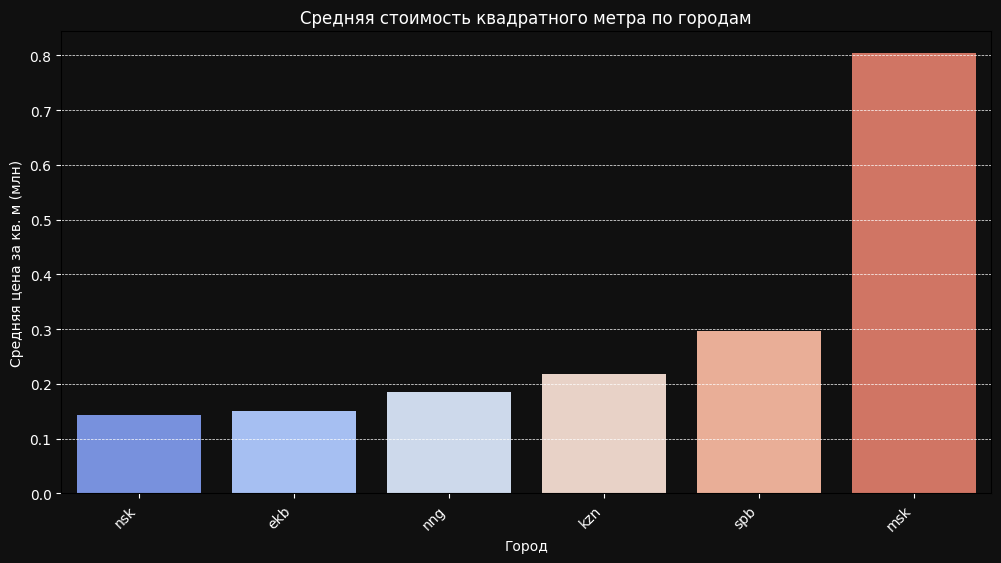

In [69]:
df['price_per_sqm'] = (df['price'] / 1_000_000) /df['total_area']
city_avg_price = df.groupby('region')['price_per_sqm'].mean().reset_index()
city_avg_price = city_avg_price.sort_values(by='price_per_sqm')

plt.figure(figsize=(12, 6))
sns.barplot(x=city_avg_price['region'], y=city_avg_price['price_per_sqm'], palette='coolwarm')

plt.xlabel("Город")
plt.ylabel("Средняя цена за кв. м (млн)")
plt.title("Средняя стоимость квадратного метра по городам")
plt.xticks(rotation=45, ha='right')

plt.show()

### Выше всего цена у москвы, далее идет петербург, а вот цены в остальных городах примерно одинаковые

In [70]:
region_mapping = {
    'msk': 6,
    'spb': 5,
    'kzn': 4,
    'ekb': 3,
    'nsk': 2,
    'nng': 1
}
df['region'] = df['region'].map(region_mapping).fillna(1).astype(int)

<ipython-input-71-47c1159e8592>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=city_avg_price['house_material'], y=city_avg_price['price_per_sqm'], palette='coolwarm')


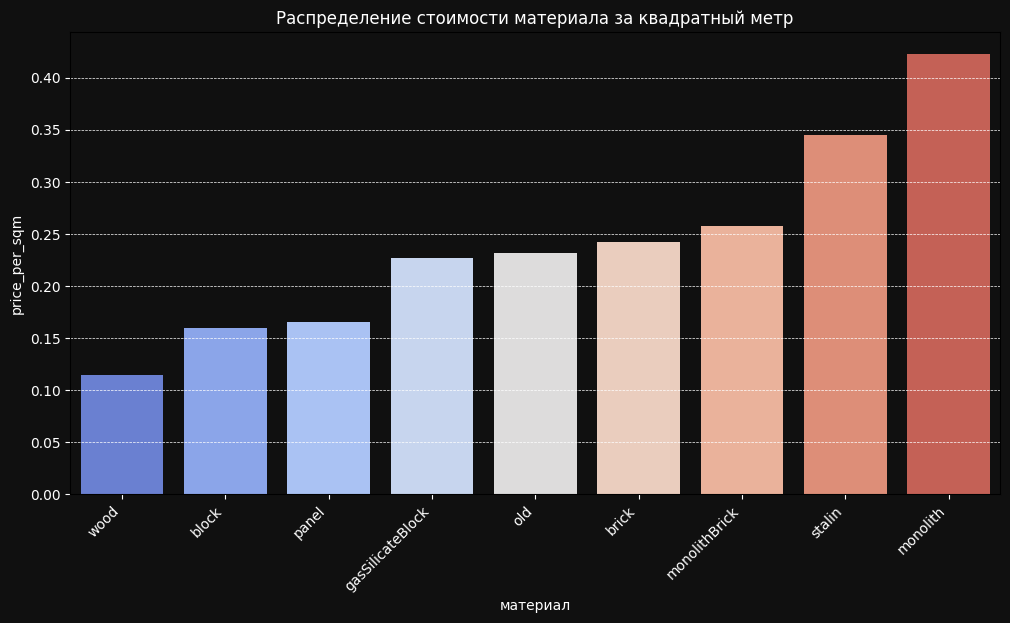

In [71]:
df['price_per_sqm'] = (df['price']/1_000_000) /df['total_area']
city_avg_price = df.groupby('house_material')['price_per_sqm'].mean().reset_index()
city_avg_price = city_avg_price.sort_values(by='price_per_sqm')

plt.figure(figsize=(12, 6))
sns.barplot(x=city_avg_price['house_material'], y=city_avg_price['price_per_sqm'], palette='coolwarm')

plt.xlabel("материал")
plt.title("Распределение стоимости материала за квадратный метр")
plt.xticks(rotation=45, ha='right')

plt.show()

### Видим, что самый дорогой - монолит и сталинки

In [72]:
material_qualities = {
    'monolith': 3,
    'stalin': 3,
    'monolithBrick': 2,
    'old': 2,
    'brick': 2,
    'gasSilicateBlock': 2,
}
df['house_material'] = df['house_material'].map(material_qualities).fillna(1).astype(int)

In [73]:
df.drop(columns=['price_per_sqm'], inplace=True)

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5978 entries, 0 to 5977
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   region              5978 non-null   int64  
 1   address             5978 non-null   object 
 2   price               5978 non-null   int64  
 3   total_area          5978 non-null   float64
 4   kitchen_area        3702 non-null   float64
 5   living_area         3834 non-null   float64
 6   rooms_count         5978 non-null   float64
 7   floor               5978 non-null   int64  
 8   floors_number       5978 non-null   int64  
 9   build_date          1497 non-null   float64
 10  isСomplete          3797 non-null   float64
 11  complitation_year   3869 non-null   float64
 12  house_material      5978 non-null   int64  
 13  parking             1432 non-null   object 
 14  decoration          1222 non-null   object 
 15  balcony             5978 non-null   float64
 16  longit

In [75]:
df = df.drop(['decoration', 'isСomplete','living_area', 'parking', 'build_date', 'kitchen_area', 'complitation_year', 'metro'], axis=1)

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5978 entries, 0 to 5977
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   region              5978 non-null   int64  
 1   address             5978 non-null   object 
 2   price               5978 non-null   int64  
 3   total_area          5978 non-null   float64
 4   rooms_count         5978 non-null   float64
 5   floor               5978 non-null   int64  
 6   floors_number       5978 non-null   int64  
 7   house_material      5978 non-null   int64  
 8   balcony             5978 non-null   float64
 9   longitude           5978 non-null   float64
 10  latitude            5978 non-null   float64
 11  passenger_elevator  5978 non-null   float64
 12  cargo_elevator      5978 non-null   float64
 13  metro_distance      5978 non-null   float64
 14  metro_transport     5978 non-null   int64  
 15  district            5978 non-null   object 
 16  is_apa

### Построим матрицу корреляции

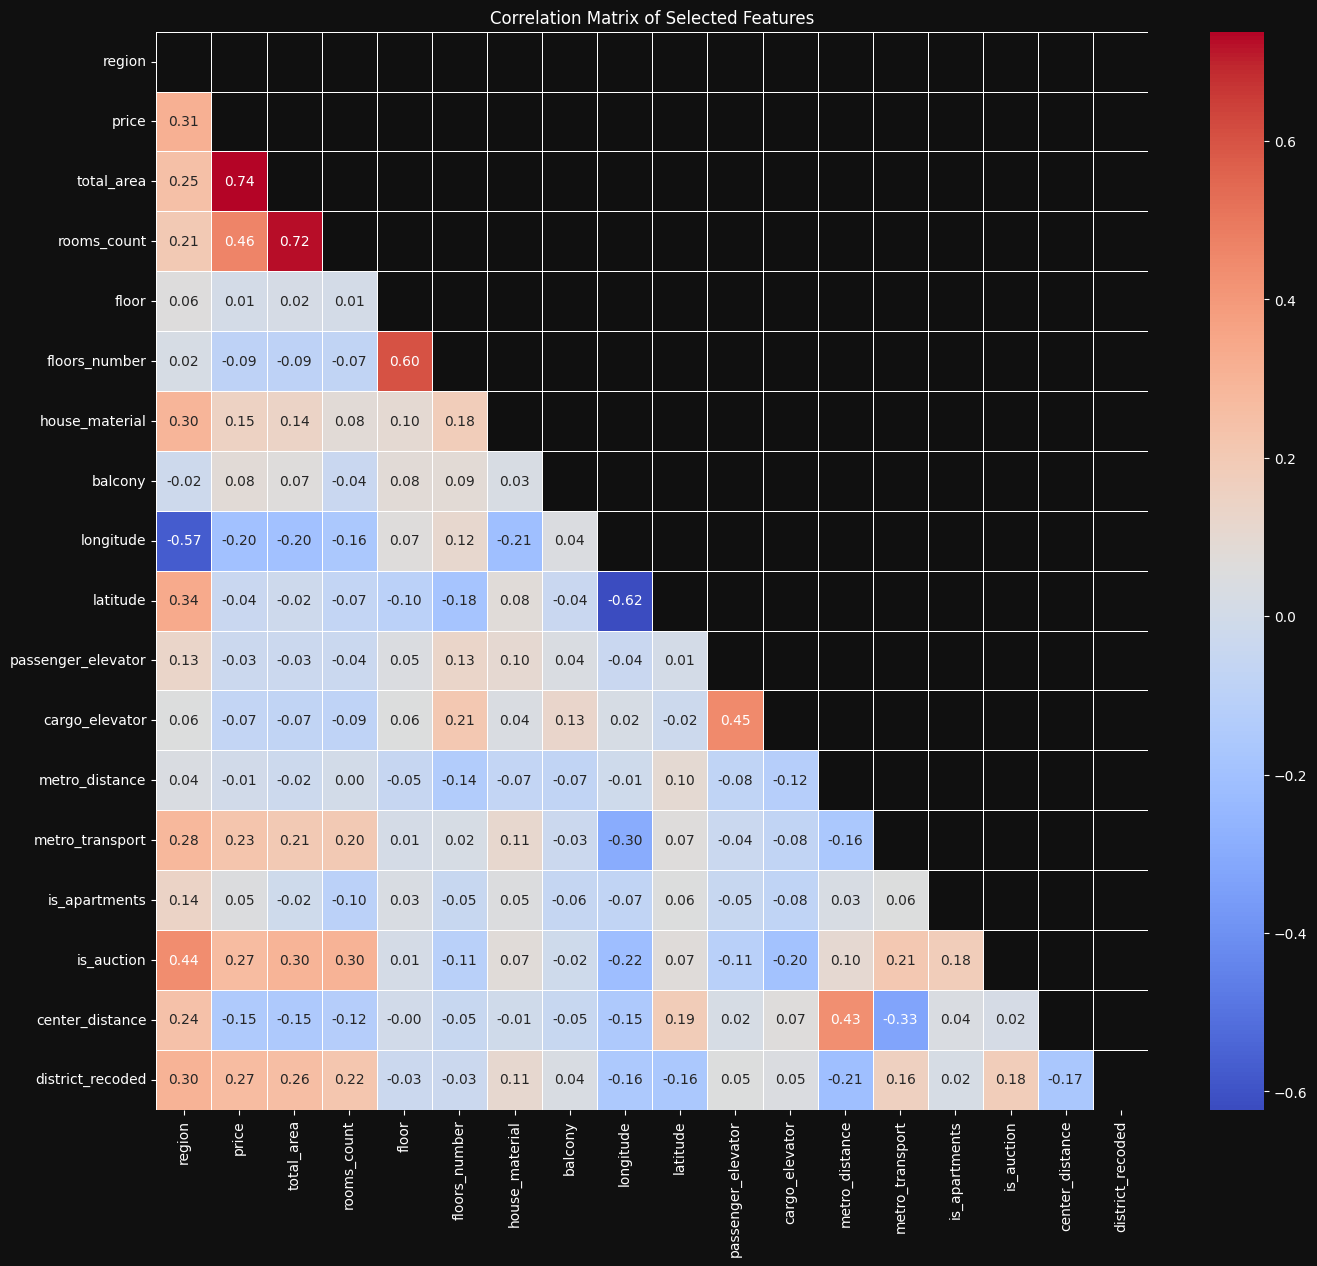

In [77]:
numeric_features = df.select_dtypes(include=np.number)
corr_matrix = numeric_features.corr()
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask = mask, linewidths=0.5)
plt.grid(axis='y', linestyle='', alpha=0.7)
plt.grid(axis='x', linestyle='', alpha=0.7)
plt.title('Correlation Matrix of Selected Features')
plt.show()

df['is_apartment'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.xlabel('is_apartment')
plt.ylabel('Количество')
plt.title('Распределение признака is_apartment')
plt.xticks(ticks=[0, 1], labels=['Нет', 'Да'], rotation=0)

plt.show()

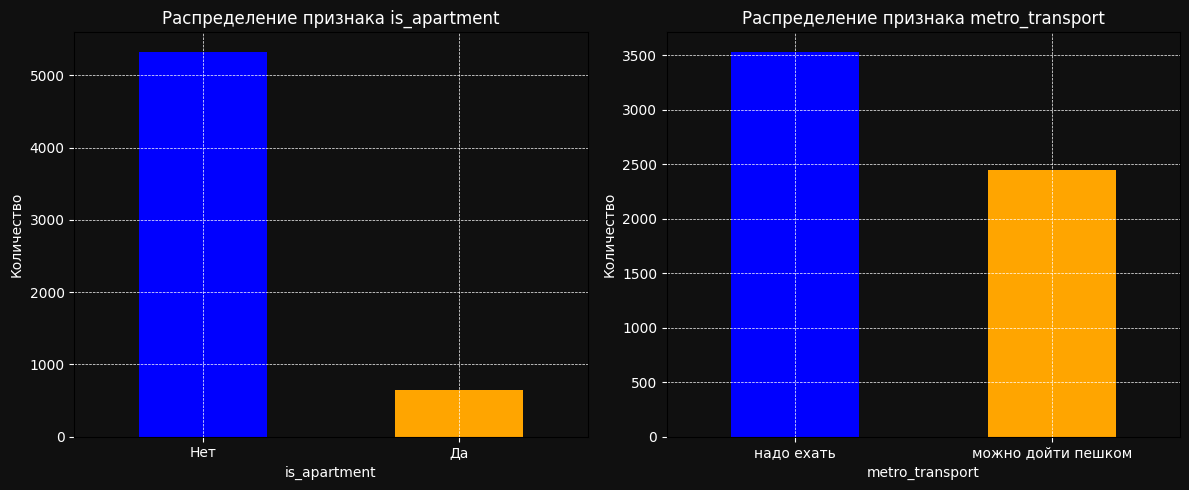

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

df['is_apartments'].value_counts().plot(kind='bar', color=['blue', 'orange'], ax=axes[0])
axes[0].set_xlabel('is_apartment')
axes[0].set_ylabel('Количество')
axes[0].set_title('Распределение признака is_apartment')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Нет', 'Да'], rotation=0)


df['metro_transport'].value_counts().plot(kind='bar', color=['blue', 'orange'], ax=axes[1])
axes[1].set_xlabel('metro_transport')
axes[1].set_ylabel('Количество')
axes[1].set_title('Распределение признака metro_transport')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['надо ехать', 'можно дойти пешком'], rotation=0)

plt.tight_layout()
plt.show()

### Преобладают квартиры, которые не являются апартаментами, так же в основном метро расположено в пешей доступности.

<ipython-input-79-f636f2d1123e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['rooms_count'], ax=axes[0], palette="coolwarm")


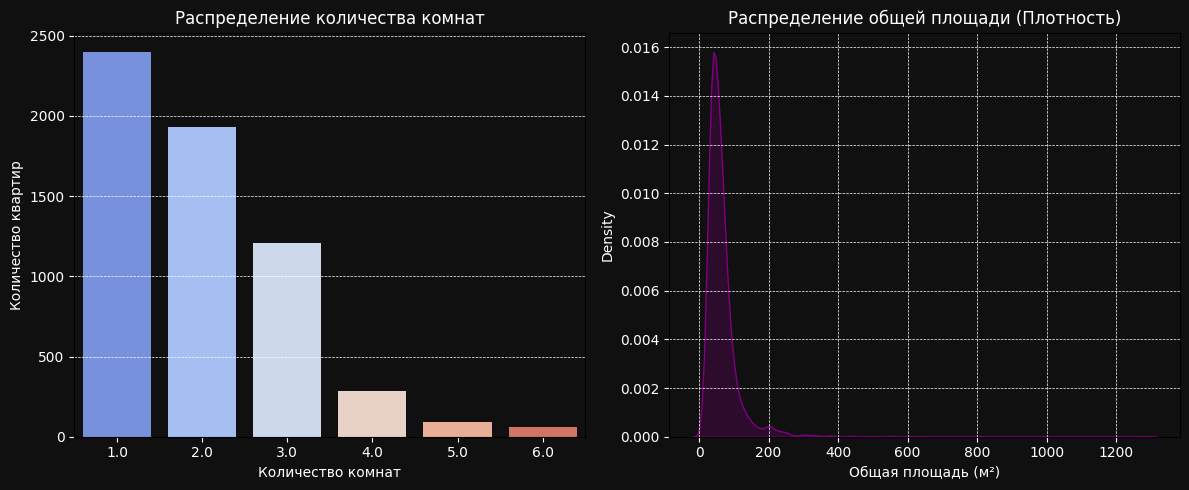

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x=df['rooms_count'], ax=axes[0], palette="coolwarm")
axes[0].set_title("Распределение количества комнат")
axes[0].set_xlabel("Количество комнат")
axes[0].set_ylabel("Количество квартир")

sns.kdeplot(df['total_area'], ax=axes[1], fill=True, color="purple")
axes[1].set_title("Распределение общей площади (Плотность)")
axes[1].set_xlabel("Общая площадь (м²)")

plt.tight_layout()
plt.show()

### Больше всего продается однокомнатных и двуxкомнатных квартир
### В основ встречаются квартиры до 200 квадратных метров

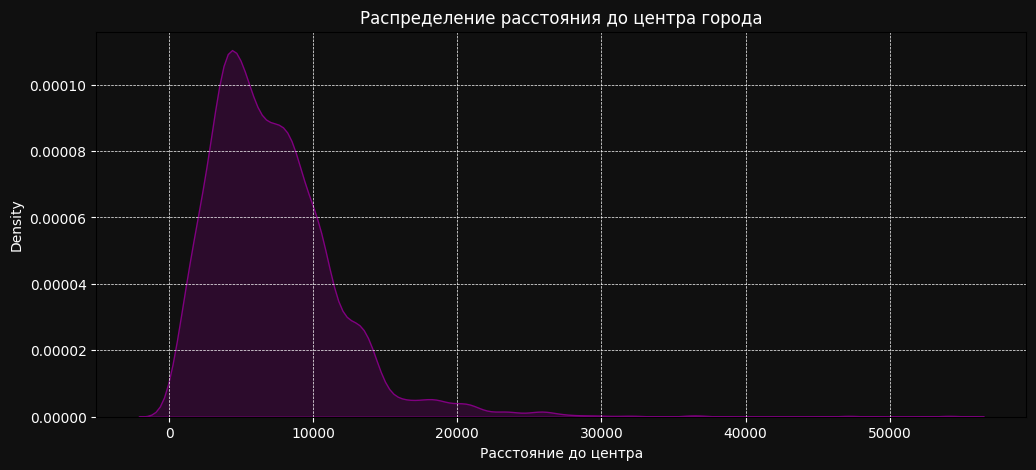

In [80]:
fig, ax = plt.subplots(figsize=(12, 5))

sns.kdeplot(df['center_distance'], ax=ax, fill=True, color="purple")
ax.set_title("Распределение расстояния до центра города")
ax.set_xlabel("Расстояние до центра")

plt.show()

## Видим, что в основном расстояние принадлежит от 0 до 1500. Но все равно есть очень отдаленные квартиры

#Гипотезы

In [81]:
 def bootstrap_ci(sample, n_resamples=1000, ci=95):
    bootstrap_means = [np.mean(np.random.choice(sample,
size=len(sample), replace=True)) for _ in range(n_resamples)]
    lower_percentile = np.percentile(bootstrap_means, (100 - ci) / 2)
    upper_percentile = np.percentile(bootstrap_means, 100 - (100 - ci)
/ 2)
    return lower_percentile, upper_percentile

In [82]:
 def compute_confidence_interval(data, confidence_level=0.95):
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    n = len(data)
    t_score = stats.t.ppf((1 + confidence_level) / 2, df=n - 1)
    ci = (mean - t_score * std / np.sqrt(n), mean + t_score * std /
np.sqrt(n))
    return ci

### Гипотеза №1: Распределения total_area, house_material, metro_distance не имеют  статистических отличий

In [88]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5978 entries, 0 to 5977
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   region              5978 non-null   object 
 1   address             5978 non-null   object 
 2   price               5978 non-null   int64  
 3   total_area          5978 non-null   float64
 4   kitchen_area        3702 non-null   float64
 5   living_area         3834 non-null   float64
 6   rooms_count         5978 non-null   float64
 7   floor               5978 non-null   int64  
 8   floors_number       5978 non-null   int64  
 9   build_date          1497 non-null   float64
 10  isСomplete          3797 non-null   float64
 11  complitation_year   3869 non-null   float64
 12  house_material      5978 non-null   object 
 13  parking             1432 non-null   object 
 14  decoration          1222 non-null   object 
 15  balcony             5978 non-null   float64
 16  longit

In [89]:
def calculate_psi(expected, actual, bins=10):
    expected_perc = np.histogram(expected, bins=bins, density=True)[0]
    actual_perc = np.histogram(actual, bins=bins, density=True)[0]
    expected_perc = expected_perc + 1e-10
    actual_perc = actual_perc + 1e-10
    expected_perc /= expected_perc.sum()
    actual_perc /= actual_perc.sum()
    psi = np.sum((expected_perc - actual_perc) * np.log(expected_perc / actual_perc))
    return psi

features_to_check = ['floor', 'rooms_count', 'total_area']
regions = df_copy['region'].unique()


In [90]:
for feature in features_to_check:
  print(f'Проверка для признака: {feature}')
  for i in range(len(regions)):
    for j in range(i+1, len(regions)):
      region_1 = regions[i]
      region_2 = regions[j]
      region_1_data = df_copy[df_copy['region'] == region_1][feature]
      region_2_data = df_copy[df_copy['region'] == region_2][feature]
      psi_value = calculate_psi(region_1_data, region_2_data)
      if psi_value < 0.1:
        print(f'PSI = {psi_value:.4f} Значимых различий между {region_1} и {region_2} нет')
      elif 0.1 <= psi_value < 0.2:
        print(f'PSI = {psi_value:.4f} Требуются наблюдения за {region_1} и {region_2} ')
      else:
        print(f'PSI = {psi_value:.4f} Есть значимые различия между {region_1} и {region_2} ')
  print("-"*50)

Проверка для признака: floor
PSI = 0.3104 Есть значимые различия между msk и spb 
PSI = 0.6925 Есть значимые различия между msk и ekb 
PSI = 0.8262 Есть значимые различия между msk и nsk 
PSI = 5.0640 Есть значимые различия между msk и kzn 
PSI = 0.3820 Есть значимые различия между msk и nng 
PSI = 0.1783 Требуются наблюдения за spb и ekb 
PSI = 0.2348 Есть значимые различия между spb и nsk 
PSI = 2.8194 Есть значимые различия между spb и kzn 
PSI = 0.0811 Значимых различий между spb и nng нет
PSI = 0.1291 Требуются наблюдения за ekb и nsk 
PSI = 2.3230 Есть значимые различия между ekb и kzn 
PSI = 0.1575 Требуются наблюдения за ekb и nng 
PSI = 1.8337 Есть значимые различия между nsk и kzn 
PSI = 0.2802 Есть значимые различия между nsk и nng 
PSI = 3.2445 Есть значимые различия между kzn и nng 
--------------------------------------------------
Проверка для признака: rooms_count
PSI = 0.6635 Есть значимые различия между msk и spb 
PSI = 1.0279 Есть значимые различия между msk и ekb 
P

### Для признака **floor**: требует наблюдения за spb и ekb, значимых различий между spb и nng нет, требуются наблюдения за ekb и nsk, ekb и nng
### Для признака **rooms_count**: требуются наблюдения за spb и ekb, spb и nng, ekb и kzn, ekb и nng, kzn и nng.
### **total_area** : Значимых различий между kzn и nng нет

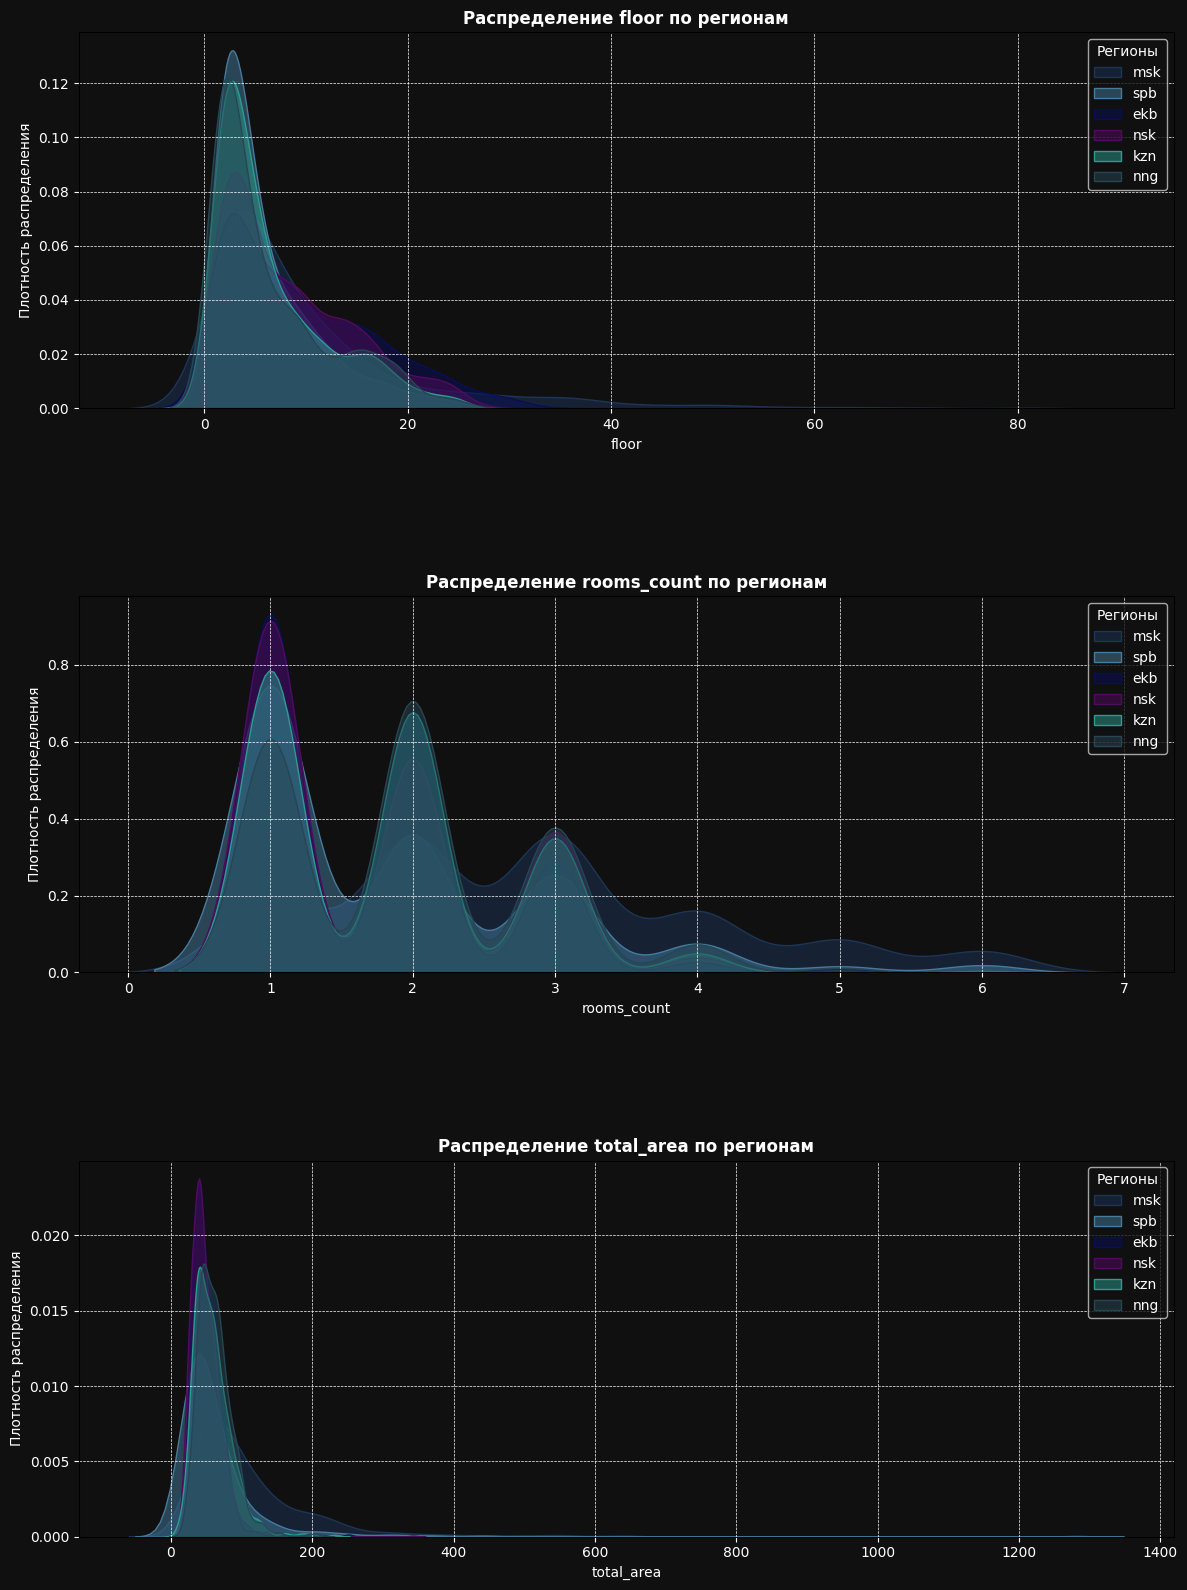

In [91]:
features_to_check = ['floor', 'rooms_count', 'total_area']

regions = df_copy['region'].unique()

kde_colors = [
    "#1D3557", "#457B9D", "#0a0e57",
    "#4f0c5e", "#2A9D8F", "#264653"
]

plt.figure(figsize=(12, 16))

for i, feature in enumerate(features_to_check, 1):
    plt.subplot(3, 1, i)

    for j, region in enumerate(regions):
        region_data = df_copy[df_copy['region'] == region][feature]
        sns.kdeplot(region_data, label=region, fill=True, alpha=0.5, color=kde_colors[j % len(kde_colors)])

    plt.title(f'Распределение {feature} по регионам', fontweight='bold')
    plt.xlabel(feature)
    plt.ylabel('Плотность распределения')
    plt.legend(title="Регионы")

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)

plt.show()

### Гипотеза 2: Нет разницы в цене между общей площадью в домах с разным количеством комнат

In [93]:
Q1 = df_copy['total_area'].quantile(0.25)
Q3 = df_copy['total_area'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_no_outliers = df_copy[(df_copy['total_area'] >= lower_bound) &
(df_copy['total_area'] <= upper_bound)]
removed_outliers = df_copy[~df_copy.index.isin(df_no_outliers.index)]
print(f"Удалено {len(removed_outliers)} выбросов.")

Удалено 420 выбросов.


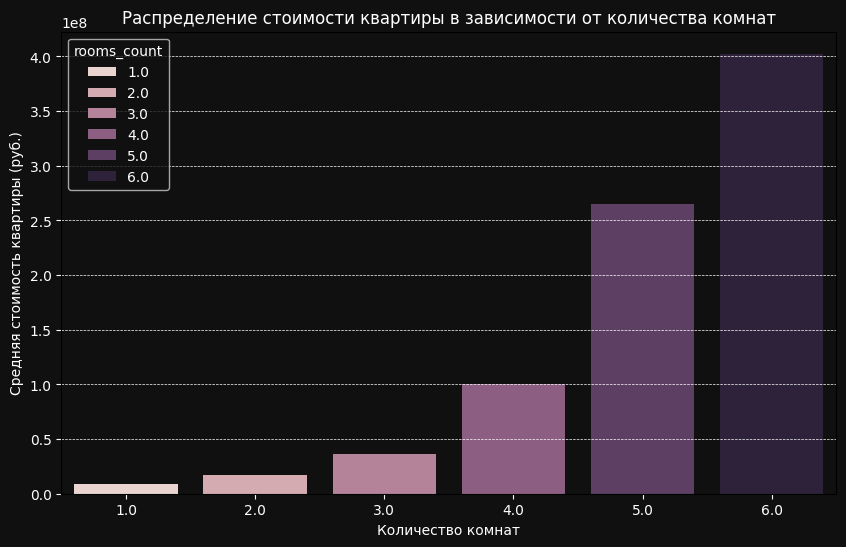

In [95]:
avg_price_by_material = df_copy.groupby('rooms_count')['price'].mean().reset_index()
avg_price_by_material = avg_price_by_material.sort_values('price', ascending=True)
plt.figure(figsize=(10, 6))
sns.barplot(x='rooms_count', y='price',hue = 'rooms_count', data=avg_price_by_material)
plt.xlabel("Количество комнат")
plt.ylabel("Средняя стоимость квартиры (руб.)")
plt.title("Распределение стоимости квартиры в зависимости от количества комнат")
plt.xticks(rotation=0)
plt.show()

### H0: нет статистически важных различий между ценой квартир с 1 комнатой в разных городах
### H1: различия есть
###  p-value = 0.05
### До этого мы выяснили что распределение стоимости не нормальное, используем тест Краскелла - Уоллиса

In [97]:
from scipy.stats import kruskal

In [98]:
df_one_room = df[df['rooms_count'] == 1]
cities = df_one_room['region'].unique()
grouped_data = [df_one_room[df_one_room['region'] == city]['price'] for city in cities]

stat, p_value = kruskal(*grouped_data)

print(f"Статистика теста: {stat}")
print(f"p-значение: {p_value}")

if p_value < 0.05:
    print("Отклоняем нулевую гипотезу. Есть статистически значимые различия между городами.")
else:
    print("Не отклоняем нулевую гипотезу. Нет статистически значимых различий между городами.")


Статистика теста: 836.750244236399
p-значение: 1.2949762991157794e-178
Отклоняем нулевую гипотезу. Есть статистически значимые различия между городами.


### Вывод: количество комнат и  общая площадь - влияют на цену, так же я поняла, что цена для однокомнатной квартиры зависит от города(это так же выполняется и для другого количества комнат)
### Требует наблюдения этаж, но далее в признаках я больше учитывала этажность здания.

## Попробуем найти наиболее подходящие признаки

In [ ]:
df_vif = df.copy()

In [ ]:
df_vif = df_vif.drop(columns=['price'])
numeric_cols = df_vif.select_dtypes(include=['int64', 'float64'])
X_vif = sm.add_constant(numeric_cols)
vif_data = pd.DataFrame()
vif_data["variable"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif_data)

              variable          VIF
0                const  3022.535306
1               region     2.367550
2           total_area     2.303579
3          rooms_count     2.279162
4                floor     1.618930
5        floors_number     1.836563
6       house_material     1.171571
7              balcony     1.059164
8            longitude     2.443109
9             latitude     2.015379
10  passenger_elevator     1.296061
11      cargo_elevator     1.387670
12      metro_distance     1.337418
13     metro_transport     1.425190
14       is_apartments     1.088316
15          is_auction     1.488929
16     center_distance     1.700649
17    district_recoded     1.391965


## Уберем признаки, которые зависимы/схожи: latitude, is_auction так как он сильно влияет на все признаки, passenger_elevator, floor

In [ ]:
df_vif = df_vif.drop(columns=['latitude', 'is_auction', 'passenger_elevator', 'floor'])

In [ ]:
numeric_cols = df_vif.select_dtypes(include=['int64', 'float64'])
X_vif = sm.add_constant(numeric_cols)
vif_data = pd.DataFrame()
vif_data["variable"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif_data)

            variable        VIF
0              const  59.081829
1             region   1.989486
2         total_area   2.290510
3        rooms_count   2.211837
4      floors_number   1.148661
5     house_material   1.161406
6            balcony   1.056785
7          longitude   1.606361
8     cargo_elevator   1.111596
9     metro_distance   1.322694
10   metro_transport   1.400294
11     is_apartments   1.057989
12   center_distance   1.681637
13  district_recoded   1.249419


### Смотрим какие признаки имеют высокий показатель vif(> 1.5) и убираем их

In [ ]:
df_vif = df_vif.drop(columns=['rooms_count', 'region', 'center_distance'])

In [ ]:
numeric_cols = df_vif.select_dtypes(include=['int64', 'float64'])
X_vif = sm.add_constant(numeric_cols)
vif_data = pd.DataFrame()
vif_data["variable"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif_data)

            variable        VIF
0              const  46.119972
1         total_area   1.156772
2      floors_number   1.140846
3     house_material   1.121036
4            balcony   1.036307
5          longitude   1.201576
6     cargo_elevator   1.092832
7     metro_distance   1.111270
8    metro_transport   1.177632
9      is_apartments   1.019188
10  district_recoded   1.148820


### Построим матрицу корреляции

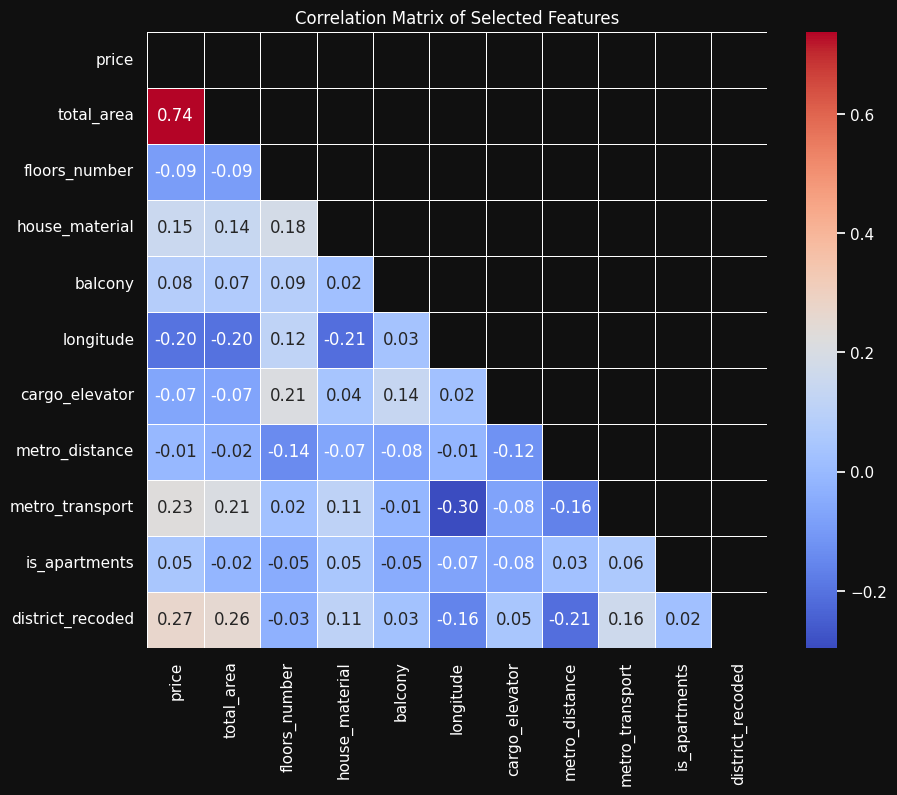

In [ ]:
potential_regressors = ['price', 'total_area', 'floors_number', 'house_material', 'balcony', 'longitude',
                        'cargo_elevator', 'metro_distance',  'metro_transport', 'is_apartments', 'district_recoded']
df_selected = df[potential_regressors]
corr_matrix = df_selected.corr()
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask = mask, linewidths=0.5)
plt.grid(axis='y', linestyle='', alpha=0.7)
plt.grid(axis='x', linestyle='', alpha=0.7)
plt.title('Correlation Matrix of Selected Features')
plt.show()


### Видим, что с целевой переменной price имеют хорошую корреляцию признаки: district_recoded, metro_transport, longitude, house_material, total_area.

In [ ]:
sns.set()

In [ ]:
potential_regressors = ['district_recoded', 'metro_transport', 'longitude', 'house_material', 'total_area']

# Построим модель регрессии с целевой переменной price и регрессорами - potential_regressors

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     1505.
Date:                Sat, 22 Mar 2025   Prob (F-statistic):               0.00
Time:                        17:21:17   Log-Likelihood:            -1.1541e+05
No. Observations:                5978   AIC:                         2.308e+05
Df Residuals:                    5972   BIC:                         2.309e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -6.08e+07   4.58e+06  

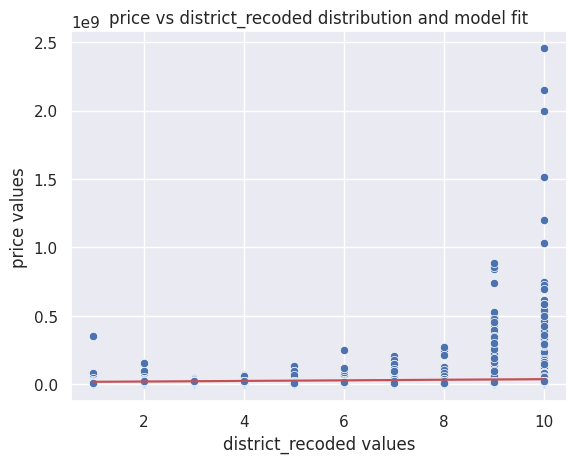

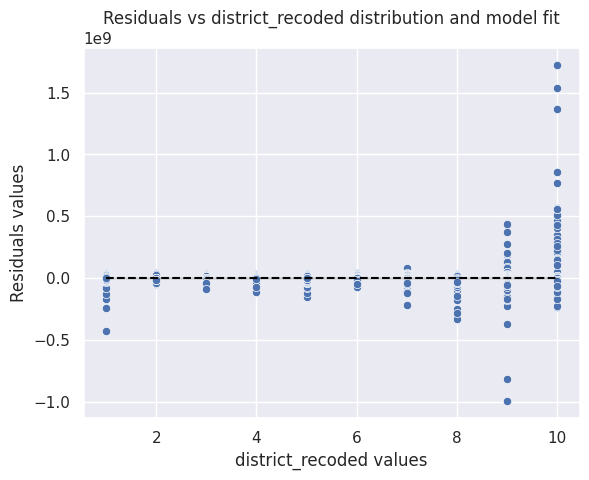

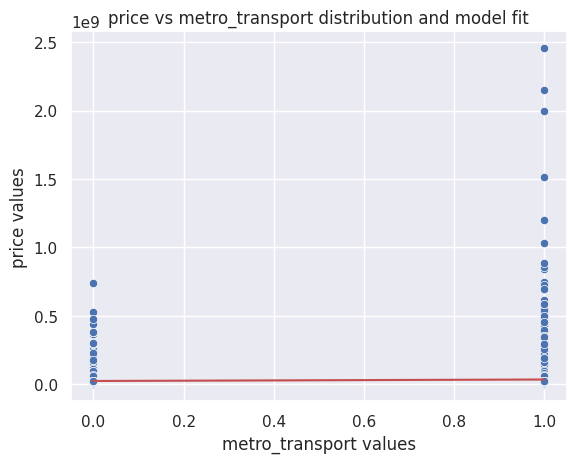

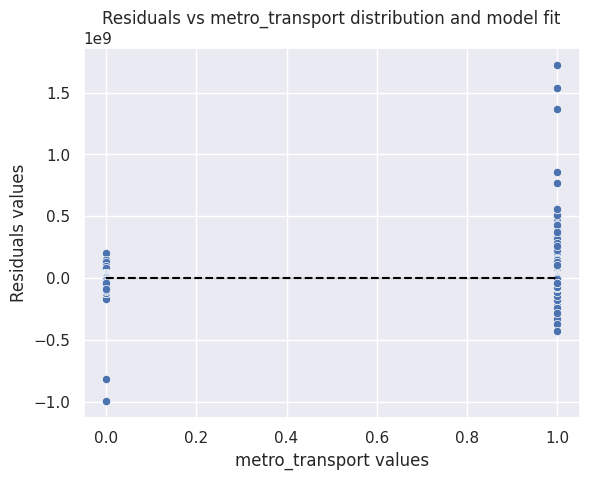

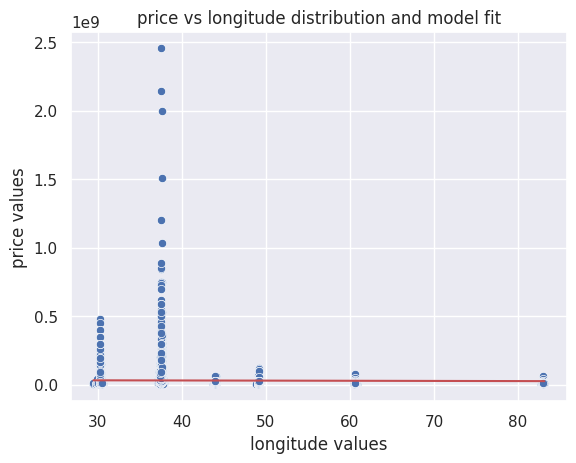

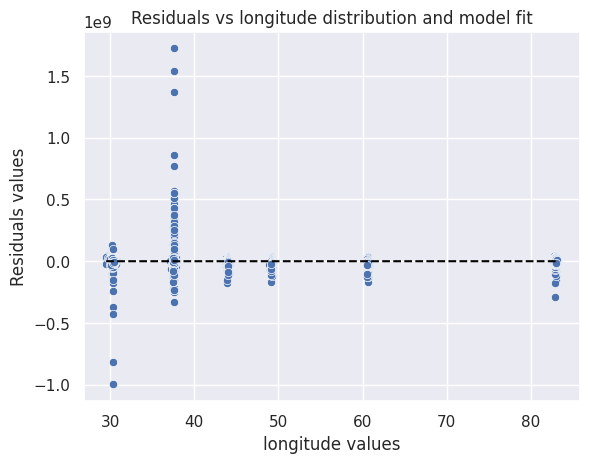

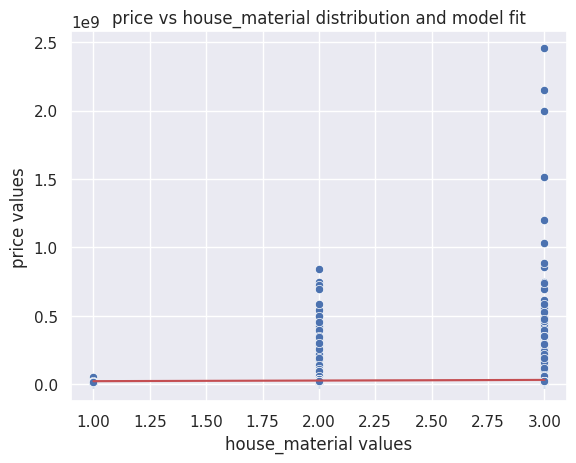

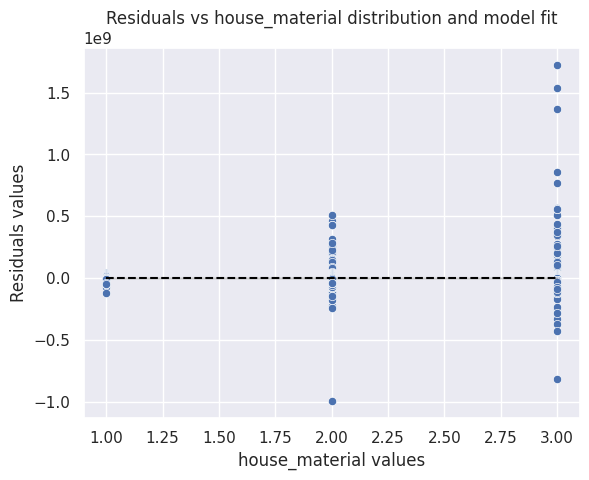

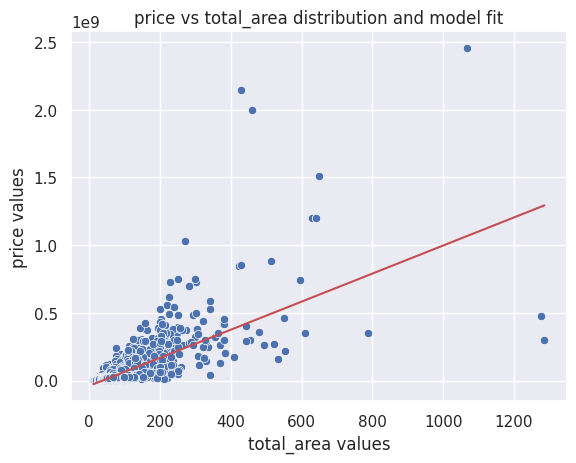

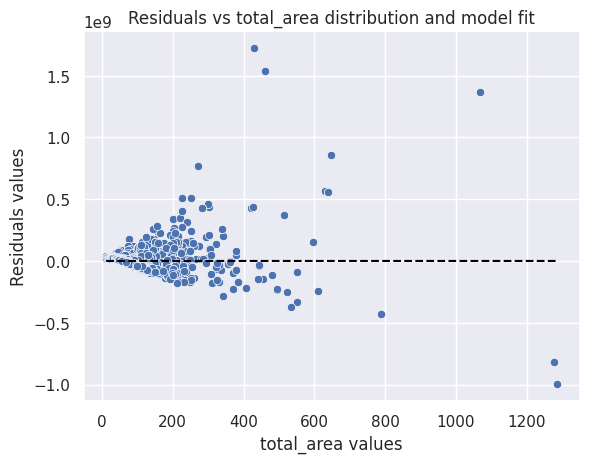

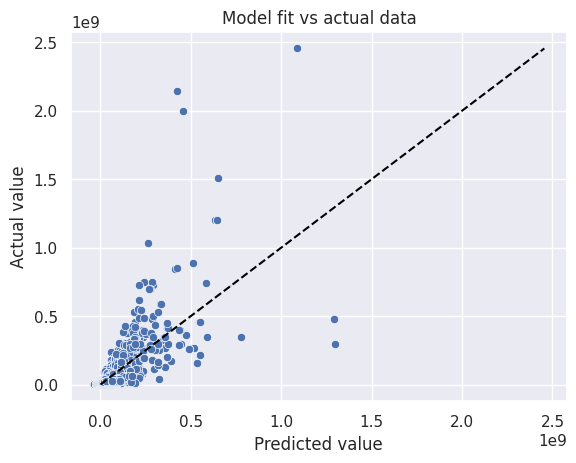

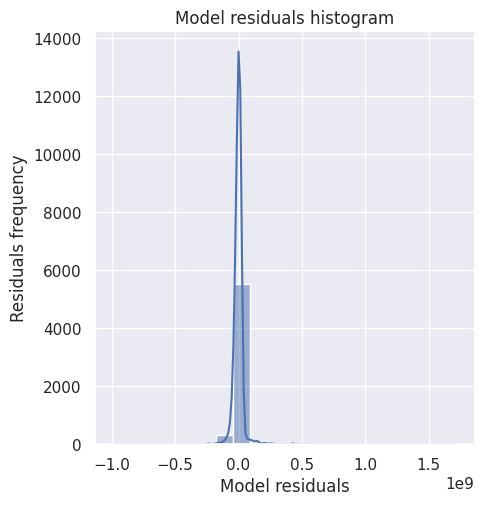

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5978.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:7654: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs - f_exp)**2 / f_exp


test  p_level  a_level a_calc a_calc >= a_level  \
0             Shapiro-Wilk test     0.95     0.05    0.0             False   
1              Epps-Pulley test     0.95     0.05      -                 -   
2   D'Agostino's K-squared test     0.95     0.05    0.0             False   
3         Anderson-Darling test     0.95     0.05                            
4       Kolmogorov–Smirnov test     0.95     0.05    0.0             False   
5               Lilliefors test     0.95     0.05  0.001             False   
6         Cramér–von Mises test     0.95     0.05    0.0             False   
7              Chi-squared test     0.95     0.05    0.0             False   
8              Jarque–Bera test     0.95     0.05    0.0             False   
9                      skewtest     0.95     0.05    0.0             False   
10                 kurtosistest     0.95     0.05    0.0             False   

          statistic critical_value statistic < critical_value  \
0          0.421444                                             
1                 -              -                      False   
2         9746.3334                                             
3        674.535029          0.786                      False   
4          0.246302                                             
5          0.246317                                             
6        123.829381                                             
7               inf                                             
8   21850224.360904                                             
9         83.253711                                             
10        53.058015                                             

                   conclusion  
0   not gaussian distribution  
1        count more than 1000  
2   not gaussian distribution  
3   not gaussian distribution  
4   not gaussian distribution  
5   not gaussian distribution  
6   not gaussian distribution  
7   not gaussian distribution  
8   not gaussian distribution  
9   not gaussian distribution  
10  not gaussian distribution

In [ ]:
df, model_heteroskedasticity = train_model(
df, target='price', feature_names=potential_regressors, show_results=True, return_norm_tests=True)

### Очень большие коэффициенты, большие ошибки, распределение остатков не явдяется нормальным, ни один тест не пройдет - так не должно быть

## Проблема в том, что цена считается в рублях, то есть значения изначально большие, попробуем считать в миллионах, так же видим смещение данных ближе к началу, попробуем взять логарифм, что позволит привести распределение к более менее нормальному распределению.

In [ ]:
features = ['total_area', 'floors_number', 'house_material', 'longitude', 'balcony',
                        'cargo_elevator', 'metro_distance',  'metro_transport', 'is_apartments', 'district_recoded']

In [ ]:
df[features] = df[features].apply(np.log1p)

In [ ]:
df['price'] = np.log1p(df['price'])

### После применения логарифмирования повысилась корреляция с целевой переменной

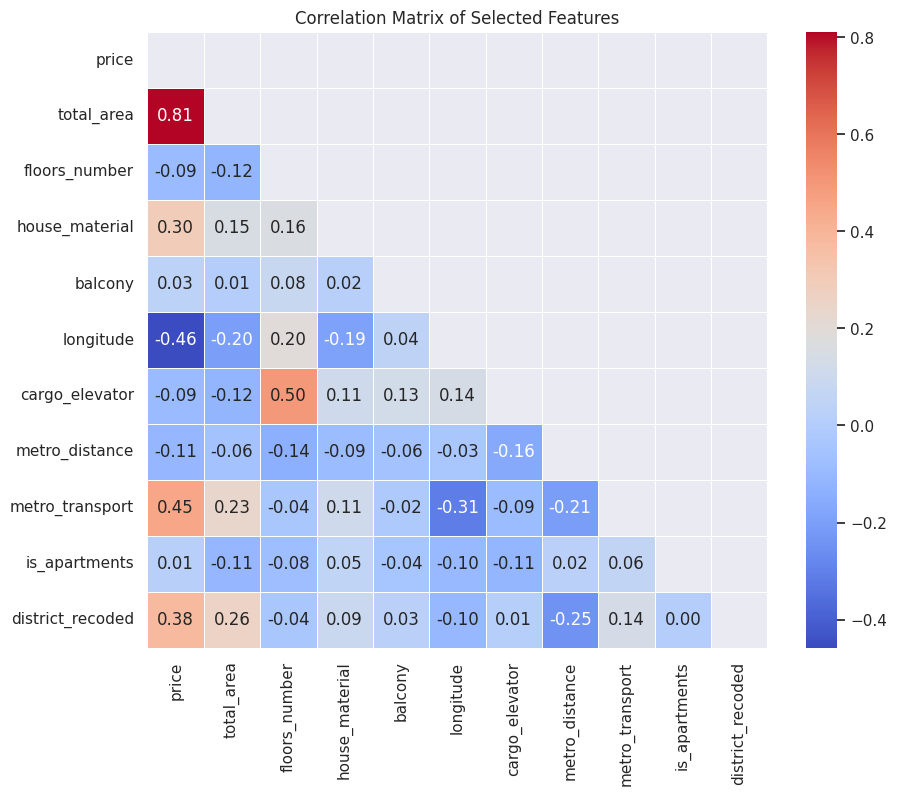

In [ ]:
potential_regressors = ['price', 'total_area', 'floors_number', 'house_material', 'balcony', 'longitude',
                        'cargo_elevator', 'metro_distance',  'metro_transport', 'is_apartments', 'district_recoded']
df_selected = df[potential_regressors]
corr_matrix = df_selected.corr()
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask = mask, linewidths=0.5)
plt.grid(axis='y', linestyle='', alpha=0.7)
plt.grid(axis='x', linestyle='', alpha=0.7)
plt.title('Correlation Matrix of Selected Features')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     5493.
Date:                Sat, 22 Mar 2025   Prob (F-statistic):               0.00
Time:                        17:23:26   Log-Likelihood:                -3434.5
No. Observations:                5978   AIC:                             6881.
Df Residuals:                    5972   BIC:                             6921.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               12.6465      0.099  

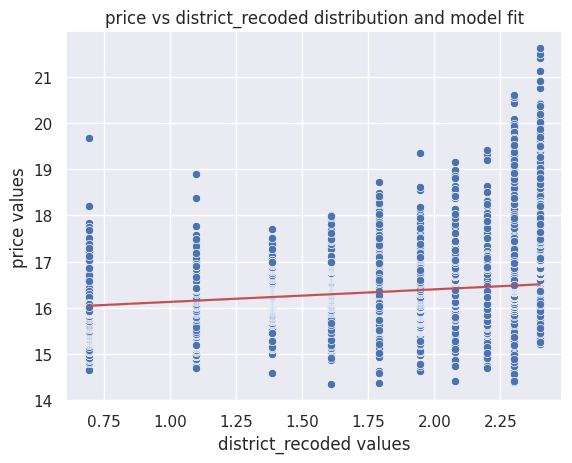

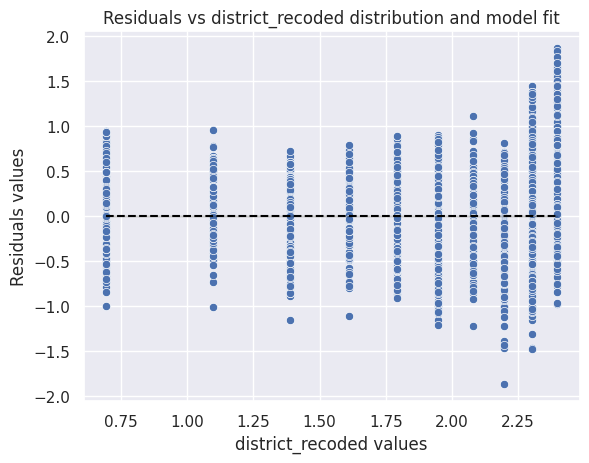

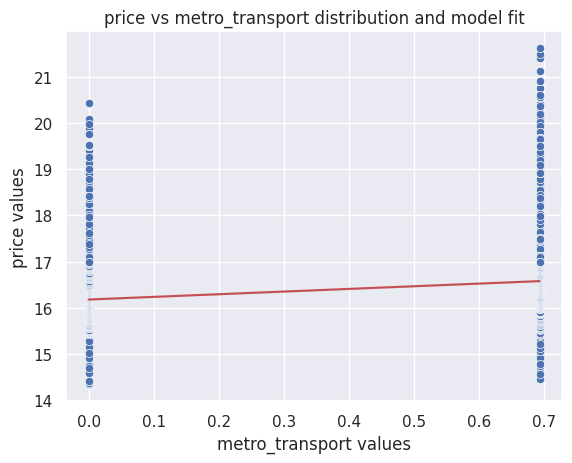

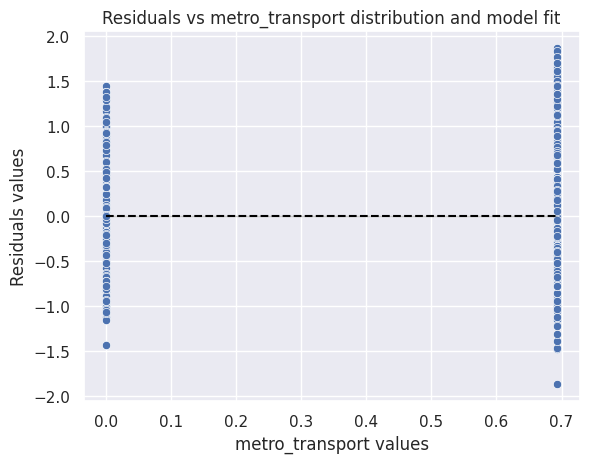

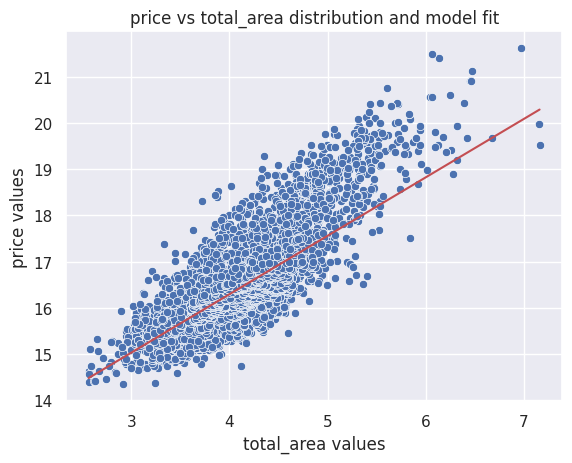

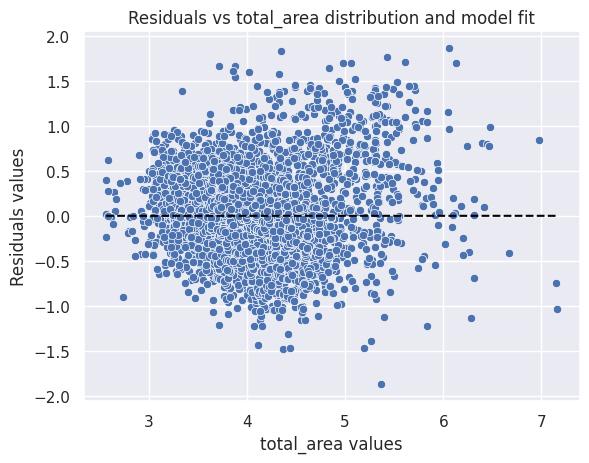

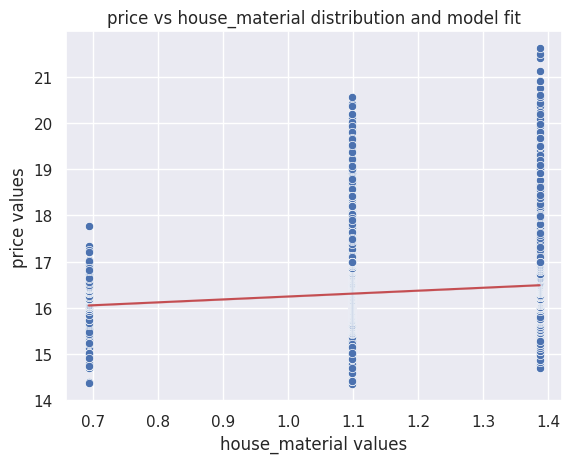

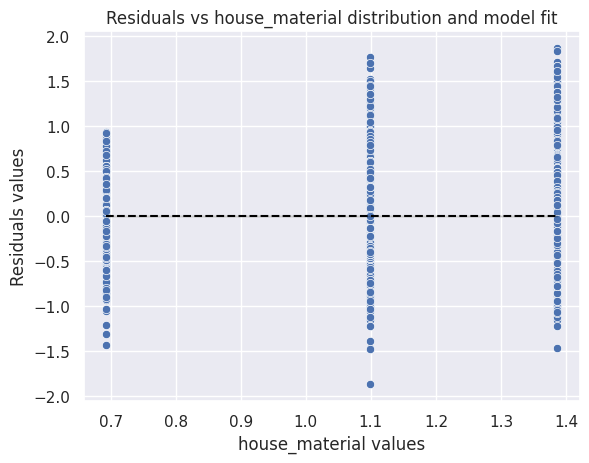

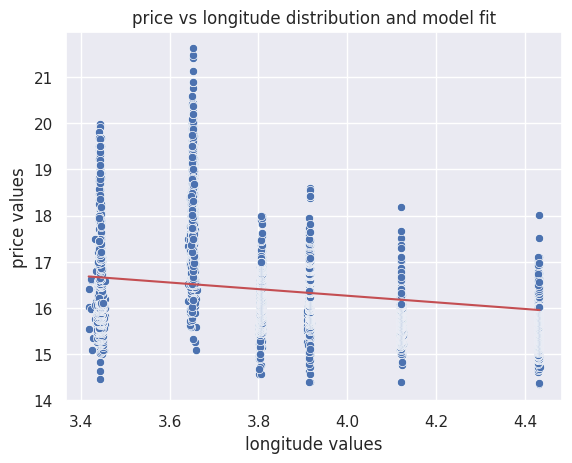

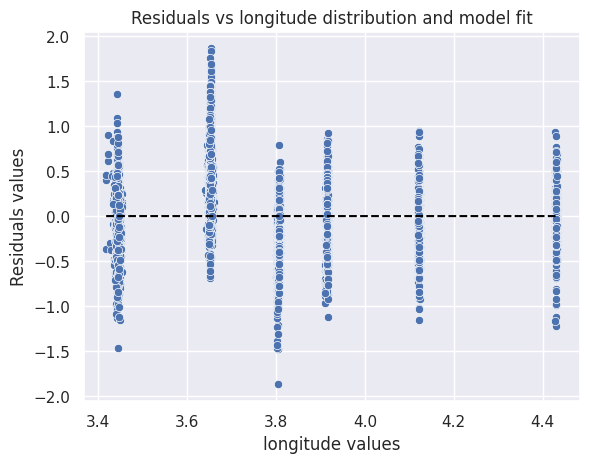

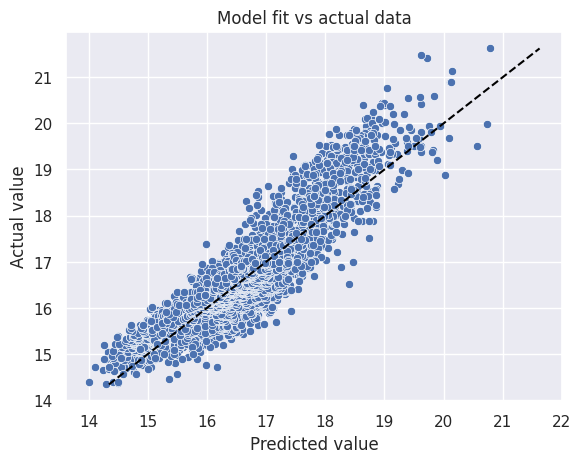

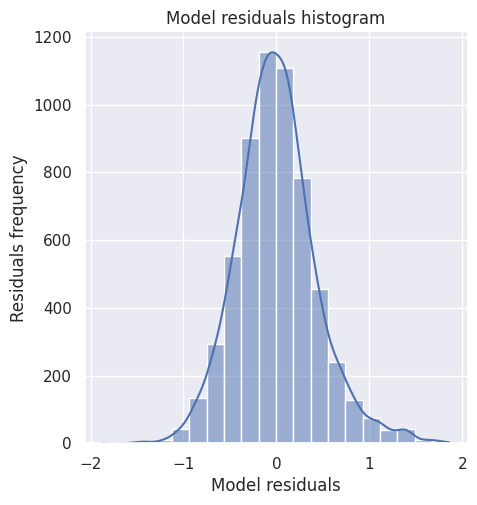

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5978.
  res = hypotest_fun_out(*samples, **kwds)


test  p_level  a_level a_calc a_calc >= a_level  \
0             Shapiro-Wilk test     0.95     0.05    0.0             False   
1              Epps-Pulley test     0.95     0.05      -                 -   
2   D'Agostino's K-squared test     0.95     0.05    0.0             False   
3         Anderson-Darling test     0.95     0.05                            
4       Kolmogorov–Smirnov test     0.95     0.05    0.0             False   
5               Lilliefors test     0.95     0.05  0.001             False   
6         Cramér–von Mises test     0.95     0.05    0.0             False   
7              Chi-squared test     0.95     0.05    1.0              True   
8              Jarque–Bera test     0.95     0.05    0.0             False   
9                      skewtest     0.95     0.05    0.0             False   
10                 kurtosistest     0.95     0.05    0.0             False   

                  statistic critical_value statistic < critical_value  \
0                   0.98498                                             
1                         -              -                      False   
2                 306.09777                                             
3                 18.615674          0.786                      False   
4                  0.041839                                             
5                  0.041854                                             
6                  2.874487                                             
7  -104780479183549005824.0                                             
8                472.543219                                             
9                 13.433568                                             
10                11.208792                                             

                   conclusion  
0   not gaussian distribution  
1        count more than 1000  
2   not gaussian distribution  
3   not gaussian distribution  
4   not gaussian distribution  
5   not gaussian distribution  
6   not gaussian distribution  
7       gaussian distribution  
8   not gaussian distribution  
9   not gaussian distribution  
10  not gaussian distribution

In [ ]:
df, model_heteroskedasticity = train_model(
df, target='price', feature_names=['district_recoded', 'metro_transport', 'total_area', 'house_material', 'longitude'], show_results=True, return_norm_tests=True)

### После применения логарифмирования R^2 вырос до 0.821. Так же R^2 совпадает с  Adj. R-squared => все признаки положительно влияют на модель. Так же видим, что распределение остатков на графики приблизилось к нормальному распределению. Единственный пройденный тест - это хи квадрат. Скорее всего проблема связана с выбросами, данные являются реальными, возможно еще из-за корреляции между регерссорами(хотя vif в пределах нормы)

### Попробуем добавить признаки

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     3523.
Date:                Sat, 22 Mar 2025   Prob (F-statistic):               0.00
Time:                        17:25:20   Log-Likelihood:                -3369.4
No. Observations:                5978   AIC:                             6757.
Df Residuals:                    5969   BIC:                             6817.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               12.4422      0.107  

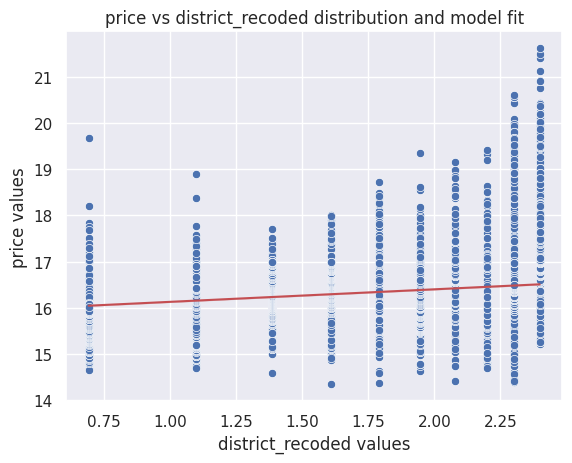

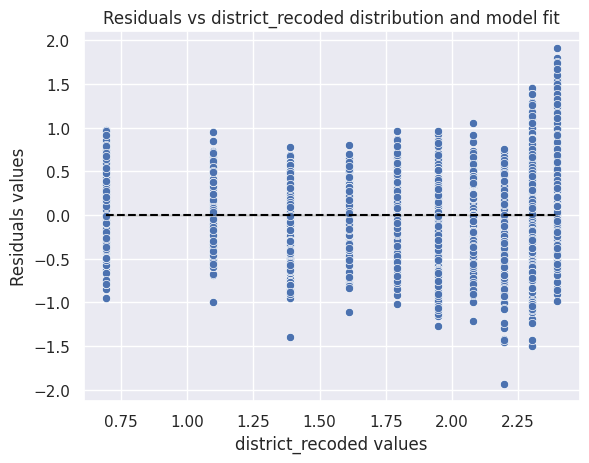

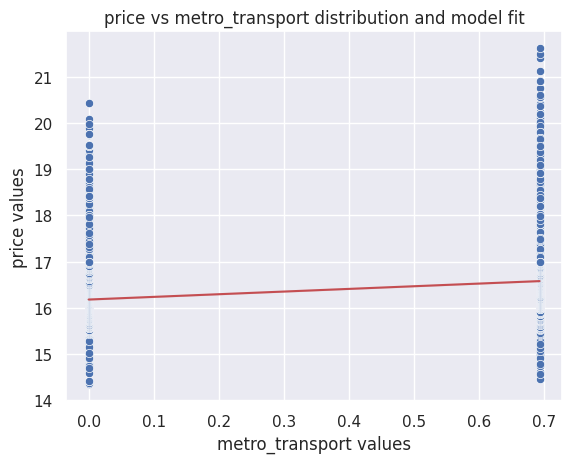

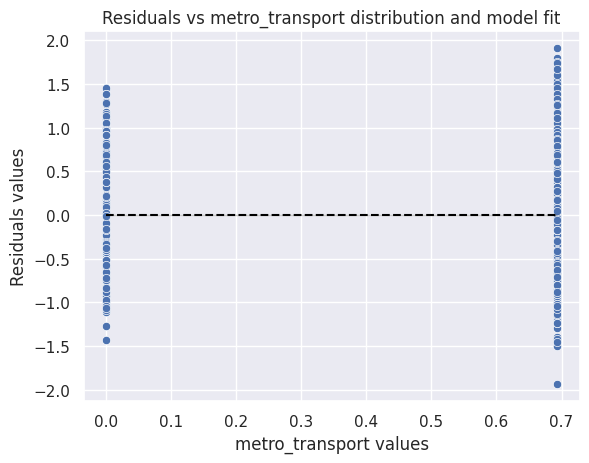

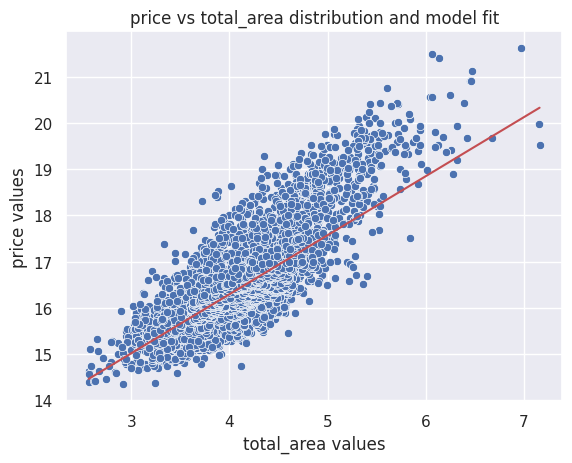

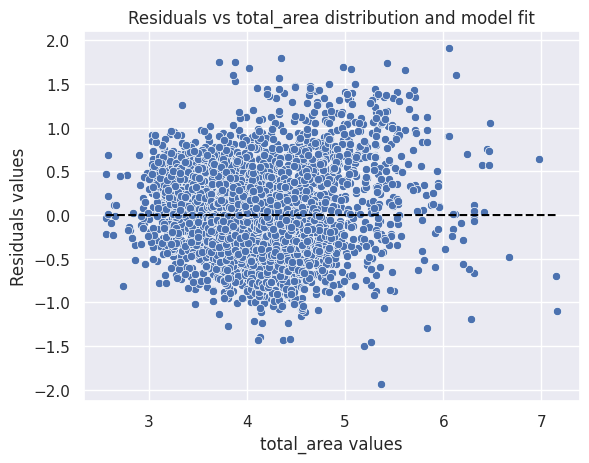

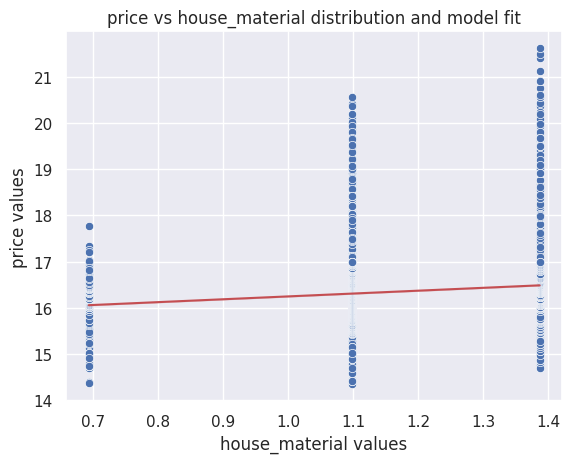

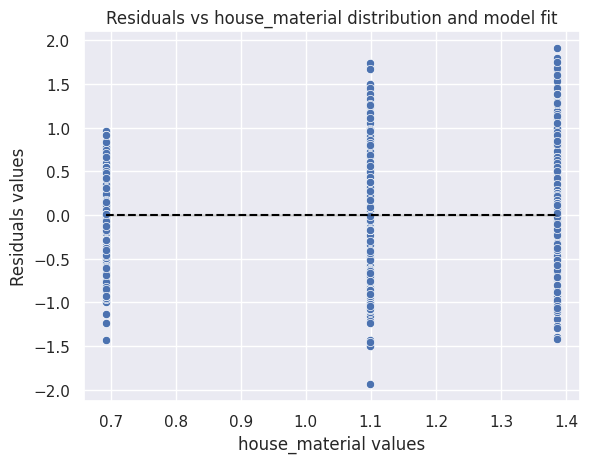

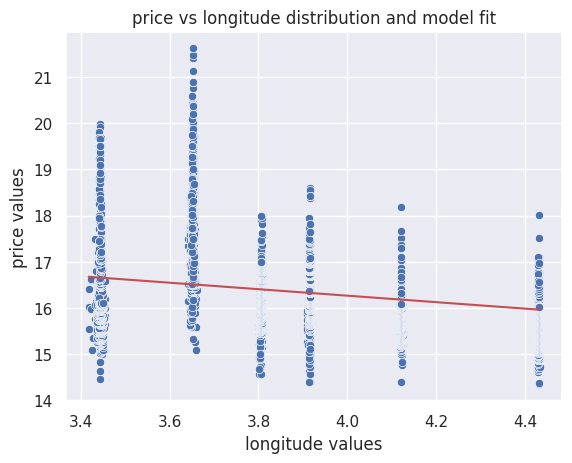

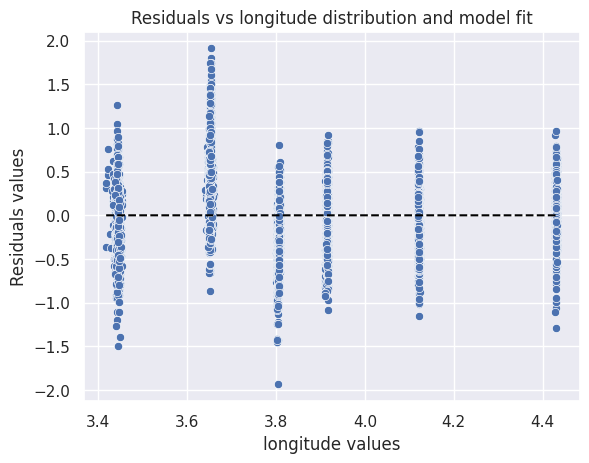

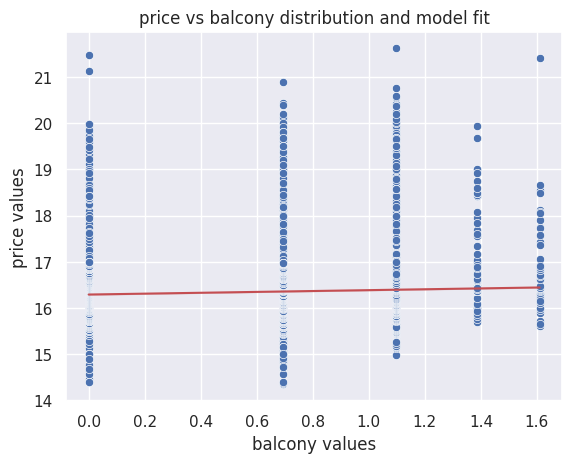

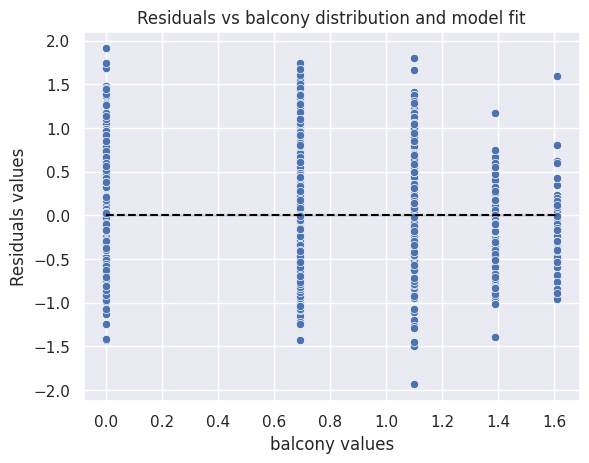

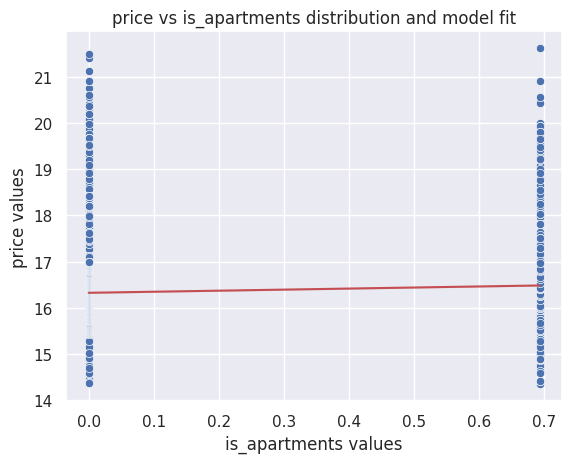

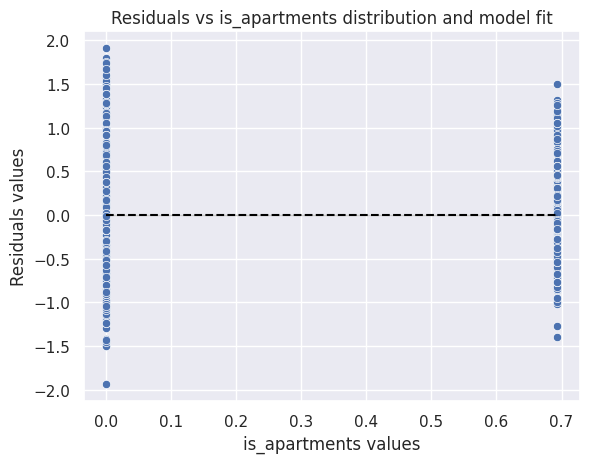

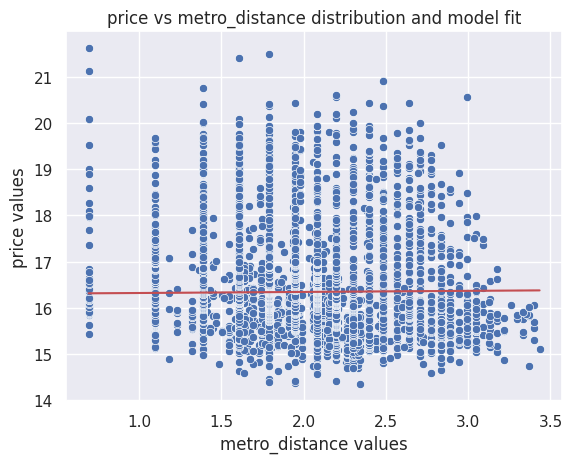

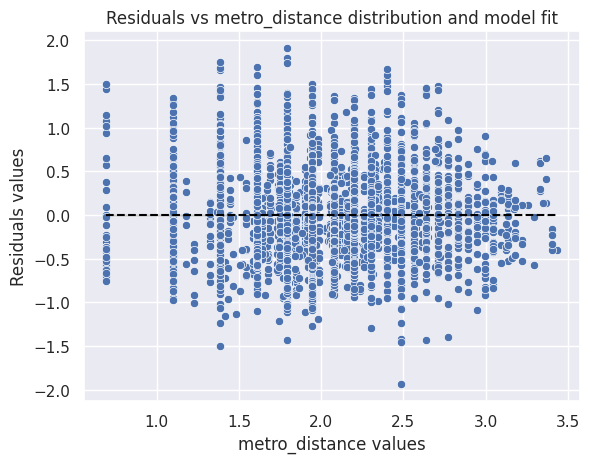

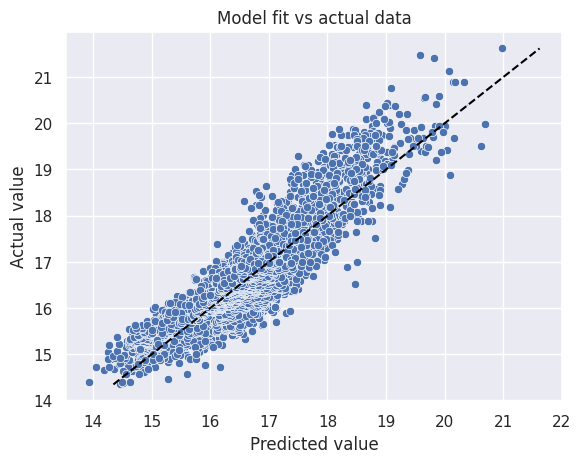

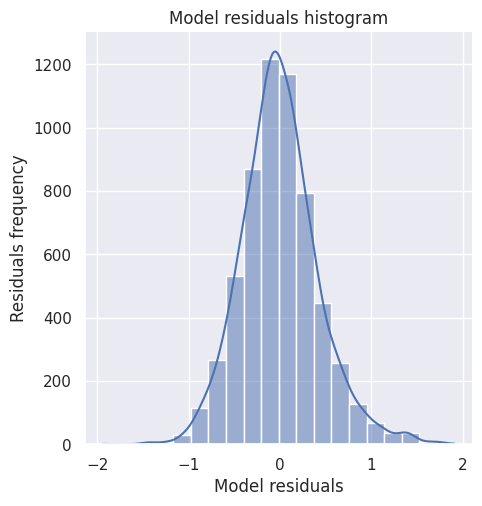

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5978.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:7654: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs - f_exp)**2 / f_exp


test  p_level  a_level a_calc a_calc >= a_level  \
0             Shapiro-Wilk test     0.95     0.05    0.0             False   
1              Epps-Pulley test     0.95     0.05      -                 -   
2   D'Agostino's K-squared test     0.95     0.05    0.0             False   
3         Anderson-Darling test     0.95     0.05                            
4       Kolmogorov–Smirnov test     0.95     0.05    0.0             False   
5               Lilliefors test     0.95     0.05  0.001             False   
6         Cramér–von Mises test     0.95     0.05    0.0             False   
7              Chi-squared test     0.95     0.05    0.0             False   
8              Jarque–Bera test     0.95     0.05    0.0             False   
9                      skewtest     0.95     0.05    0.0             False   
10                 kurtosistest     0.95     0.05    0.0             False   

     statistic critical_value statistic < critical_value  \
0     0.985688                                             
1            -              -                      False   
2   298.268511                                             
3    17.754737          0.786                      False   
4     0.041832                                             
5     0.041847                                             
6     2.841143                                             
7          inf                                             
8   468.471809                                             
9    13.042199                                             
10     11.3212                                             

                   conclusion  
0   not gaussian distribution  
1        count more than 1000  
2   not gaussian distribution  
3   not gaussian distribution  
4   not gaussian distribution  
5   not gaussian distribution  
6   not gaussian distribution  
7   not gaussian distribution  
8   not gaussian distribution  
9   not gaussian distribution  
10  not gaussian distribution

In [ ]:
df, model_heteroskedasticity = train_model(
df, target='price', feature_names=['district_recoded', 'metro_transport', 'total_area', 'house_material', 'longitude',  'balcony', 'is_apartments', 'metro_distance'], show_results=True, return_norm_tests=True)

### Метрика улучшилась до 0.825, но теперь ни один тест не пройден. Я бы выбрала предыдущую модель так как там стандартное отклонение меньше.

### Благодаря проверке гипотез, я поняла что цена на крвартиру завсит от региона и от общей площади, что в дальнейшем помогло при построении модели и заполнении пропусков.

### Выводы: датасет довольно сложный, но было супер интересно пробовать различные идеи и подходы